In [1]:
import os
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
def specificity_score(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    specificity = TN/(TN+FP)
    return specificity

def classification_evaluation(y_true, y_pred, y_score):
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    auc = metrics.roc_auc_score(y_true, y_score)
    f1 = metrics.f1_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    evaluation = {'accuracy':accuracy, 'recall':recall, 'precision':precision, 'f1':f1, 'auc':auc, 'specificity':specificity}
    return evaluation

### 绘制混淆矩阵

有些概念比较混淆，例如准确率、精准率等。

准确率(accurary)：（正确预测0的个数+正确预测1的个数）/ 所有样本数

精确率(precision)=查准率：预测为1中真实为1的样本数 / 预测为1的样本数

真阳性率(True Positive Rate, TPR)=灵敏度(sensitivity)=敏感度=召回率(recall)=标签1的查全率：正确预测1的个数 / 实际1的样本数

假阳性率(False Positive Rate, FPR)=1-真阴率 ：预测为0中真实为1的样本数 / 实际0的样本数

真阴性率(True Negative Rate,TNR)=特异度(specificity)=标签0的查全率：正确预测0的个数 / 实际0的样本数

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc  
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, ScalarFormatter
import numpy as np
import pandas as pd

# Set the global font same as the sci-paper.
plt.rc('font',family='Times New Roman')
# 修改公式中默认字体
plt.rcParams['mathtext.default'] = 'regular'
# Set the figure size
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.labelsize'] = 42

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['lines.color'] = 'r'

# 定义字体font1
font1 = {'family': 'Times New Roman',
'weight': 'normal',
'size': 15,
}


from math import sqrt

# Calculate the confidence interval of the 
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

# Define the ROC Plot on the subplot(ax).
def roc_plot_inside(y_true, y_score, label, ax, positive=1):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    fpr,tpr,threshold = roc_curve(y_true, y_score, pos_label=positive) ###计算真正率和假                            
    roc_auc = auc(fpr,tpr) ###计算auc的值
    roc_auc_low, roc_auc_up = roc_auc_ci(y_true, y_score, positive)
    if roc_auc_up > 1.0:
        roc_auc_up = 1.0
    ax.plot(fpr, tpr, 
             lw=2, label='{3} (AUC={0:0.3f},95%CI:({1:0.3f}-{2:0.3f}))'.format(roc_auc,roc_auc_low,roc_auc_up,label)) ###假正率为横坐标，真正率为纵坐标做曲线
    
    
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix    #导入计算混淆矩阵的包
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from pylab import mpl
mpl.rcParams['font.family'] = 'Times New Roman'
import seaborn as sns #导入包

# To draw the  confusion-matrix based on the truth and predicted label.
# out_fig: the output fig name(include path);
def confusion_matrix_plot(true_label, predict, out_fig, fig_title=''):
    C = confusion_matrix(true_label, predict)
    fig, ax = plt.subplots(figsize=(12,10))
    df=pd.DataFrame(C)
    sns.heatmap(df, fmt='g', annot=True, cmap='Blues', ax=ax, annot_kws={"size":35})
    ax.set_xlabel('Predict',fontsize=42, color='k') #x轴label的文本和字体大小
    ax.set_ylabel('True',fontsize=42, color='k') #y轴label的文本和字体大小
    ax.tick_params(labelsize=35)
    #设置colorbar的刻度字体大小
    cax = plt.gcf().axes[-1] 
    cax.tick_params(labelsize=35)
    #设置colorbar的label文本和字体大小
    cbar = ax.collections[0].colorbar
    # cbar.set_label(r'$NMI$',fontdict=font1)
    ax.set_title(fig_title, fontsize=42)
    plt.savefig(out_fig,dpi=300, bbox_inches='tight')
    
def calcu_evaluation(true_label, predict):
    C = confusion_matrix(true_label, predict)
    TP = C[1,1]
    FP = C[0,1]
    TN = C[0,0]
    FN = C[1,0]
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return sensitivity, specificity, accuracy

### Load data

In [4]:
cwd = os.getcwd()
traindir = '../Feature_filter/Feas_data'
testdir = '../Feature_filter/Feas_data_test'
imgdir = os.path.join(cwd, 'IMG')
modeldir = os.path.join(cwd, 'Model')
tag_cols = ['pid', 'label', 'series','image', 'mask']
sequence_id = [2, 3, 4]
# Generate the random seed
random_state = random.randint(1,10000)

SSM_test_slist = [pd.read_excel(os.path.join(testdir, 'SSM_test.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# Test data
SSM_test_y = [df['label'] for df in SSM_test_slist]
SSM_test_x = [df.drop(tag_cols, axis=1) for df in SSM_test_slist]
SSM_test_x = [standardscaler.fit_transform(df) for df in SSM_test_x]

SSM2_test_y, SSM3_test_y, SSM4_test_y = (y_.to_list() for y_ in SSM_test_y)
SSM2_test_x, SSM3_test_x, SSM4_test_x = (x_ for x_ in SSM_test_x)

# DSM
Dtag_cols = ['pid', 'label']
DSM_test_slist = [pd.read_excel(os.path.join(testdir, 'DSM_test.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# Test data
DSM_test_y = [df['label'] for df in DSM_test_slist]
DSM_test_x = [df.drop(Dtag_cols, axis=1) for df in DSM_test_slist]
#DSM_test_x = [standardscaler.fit_transform(df) for df in DSM_test_x]
DSM2_test_y, DSM3_test_y, DSM4_test_y = (y_.to_list() for y_ in DSM_test_y)
DSM2_test_x, DSM3_test_x, DSM4_test_x = (x_ for x_ in DSM_test_x)


# ASM
Atag_cols = ['pid', 'label']
ASM_test = pd.read_csv(os.path.join(testdir, 'ASM_test.csv')) 
# Train data
standardscaler = StandardScaler()
# Test data
ASM_test_y = ASM_test['label']
ASM_test_x =ASM_test.drop(Dtag_cols, axis=1)
ASM_test_x = standardscaler.fit_transform(ASM_test_x)

# Clinical
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test.csv')) 
DSM_test_slist[1].head()
Clinical_test.head()
# Train data
standardscaler = StandardScaler()
# Test data
Clinical_test_y = Clinical_test['label']
Clinical_test_x = Clinical_test.drop(Dtag_cols, axis=1)
#Clinical_test_x = standardscaler.fit_transform(Clinical_test_x)

,pid,label,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
0,5,1,0.797085,0.592704,-0.557901,-0.668887,-0.923962,-0.042202,0.362689
1,6,1,0.710836,0.190043,-0.354496,0.938193,-0.438992,0.703784,0.044257
2,7,1,0.611513,-1.768737,-0.476457,2.215376,-1.323789,0.271287,-1.020230
3,17,1,-1.189034,1.285826,-0.943225,-0.708169,-2.687189,0.753846,0.516276
4,19,1,0.421419,-0.341289,-0.725443,-0.688572,0.037356,0.591782,0.882457


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,5,1,2,1.317512,0,-0.080240,0,-0.653564,2,0,1,0.053828
1,6,1,2,1.384848,0,-0.063505,0,-0.361334,2,2,1,1.492248
2,7,1,3,-0.166941,0,-0.229288,0,0.324561,2,3,1,4.500577
3,17,1,3,-0.368949,0,-0.284774,0,-0.682545,2,2,1,-0.364549
4,19,1,2,1.565431,1,-0.050291,0,0.562451,2,3,1,1.336851


#### SSM2

In [5]:
SSM2_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM2.model')) 
SSM2_KNN_pred = SSM2_KNN.predict(SSM2_test_x)
SSM2_KNN_score = SSM2_KNN.predict_proba(SSM2_test_x)
SSM2_KNN_true = SSM2_test_y  #真实标签

SSM2_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM2.model')) 
SSM2_SVM_pred = SSM2_SVM.predict(SSM2_test_x)
SSM2_SVM_score = SSM2_SVM.predict_proba(SSM2_test_x)
SSM2_SVM_true = SSM2_test_y  #真实标签

SSM2_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM2.model')) 
SSM2_NaiveBayes_pred = SSM2_NaiveBayes.predict(SSM2_test_x)
SSM2_NaiveBayes_score = SSM2_NaiveBayes.predict_proba(SSM2_test_x)
SSM2_NaiveBayes_true = SSM2_test_y  #真实标签

SSM2_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM2.model')) 
SSM2_LogisticRegression_pred = SSM2_LogisticRegression.predict(SSM2_test_x)
SSM2_LogisticRegression_score = SSM2_LogisticRegression.predict_proba(SSM2_test_x)
SSM2_LogisticRegression_true = SSM2_test_y  #真实标签

SSM2_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM2.model')) 
SSM2_RandomForest_pred = SSM2_RandomForest.predict(SSM2_test_x)
SSM2_RandomForest_score = SSM2_RandomForest.predict_proba(SSM2_test_x)
SSM2_RandomForest_true = SSM2_test_y  #真实标签

SSM2_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM2.model')) 
SSM2_LightGBM_pred = SSM2_LightGBM.predict(SSM2_test_x)
SSM2_LightGBM_score = SSM2_LightGBM.predict_proba(SSM2_test_x)
SSM2_LightGBM_true = SSM2_test_y  #真实标签
 
SSM2_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM2.model')) 
SSM2_XGBoost_pred = SSM2_XGBoost.predict(SSM2_test_x)
SSM2_XGBoost_score = SSM2_XGBoost.predict_proba(SSM2_test_x)
SSM2_XGBoost_true = SSM2_test_y  #真实标签

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

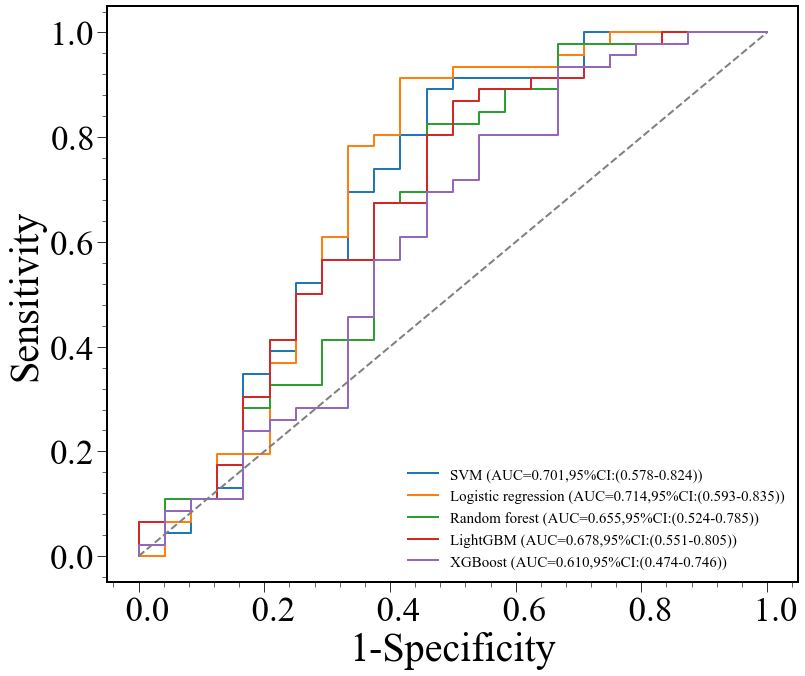

In [6]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(SSM2_KNN_true, SSM2_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM2_SVM_true, SSM2_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(SSM2_NaiveBayes_true, SSM2_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM2_LogisticRegression_true, SSM2_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM2_RandomForest_true, SSM2_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM2_LightGBM_true, SSM2_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM2_XGBoost_true, SSM2_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T2WI', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/SSM_T2WI_ROC.png", dpi=300)

#### SSM3

In [7]:
SSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM3.model')) 
SSM3_KNN_pred = SSM3_KNN.predict(SSM3_test_x)
SSM3_KNN_score = SSM3_KNN.predict_proba(SSM3_test_x)
SSM3_KNN_true = SSM3_test_y  #真实标签

SSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM3.model')) 
SSM3_SVM_pred = SSM3_SVM.predict(SSM3_test_x)
SSM3_SVM_score = SSM3_SVM.predict_proba(SSM3_test_x)
SSM3_SVM_true = SSM3_test_y  #真实标签

SSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM3.model')) 
SSM3_NaiveBayes_pred = SSM3_NaiveBayes.predict(SSM3_test_x)
SSM3_NaiveBayes_score = SSM3_NaiveBayes.predict_proba(SSM3_test_x)
SSM3_NaiveBayes_true = SSM3_test_y  #真实标签

SSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM3.model')) 
SSM3_LogisticRegression_pred = SSM3_LogisticRegression.predict(SSM3_test_x)
SSM3_LogisticRegression_score = SSM3_LogisticRegression.predict_proba(SSM3_test_x)
SSM3_LogisticRegression_true = SSM3_test_y  #真实标签

SSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM3.model')) 
SSM3_RandomForest_pred = SSM3_RandomForest.predict(SSM3_test_x)
SSM3_RandomForest_score = SSM3_RandomForest.predict_proba(SSM3_test_x)
SSM3_RandomForest_true = SSM3_test_y  #真实标签

SSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM3.model')) 
SSM3_LightGBM_pred = SSM3_LightGBM.predict(SSM3_test_x)
SSM3_LightGBM_score = SSM3_LightGBM.predict_proba(SSM3_test_x)
SSM3_LightGBM_true = SSM3_test_y  #真实标签

SSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM3.model')) 
SSM3_XGBoost_pred = SSM3_XGBoost.predict(SSM3_test_x)
SSM3_XGBoost_score = SSM3_XGBoost.predict_proba(SSM3_test_x)
SSM3_XGBoost_true = SSM3_test_y  #真实标签

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

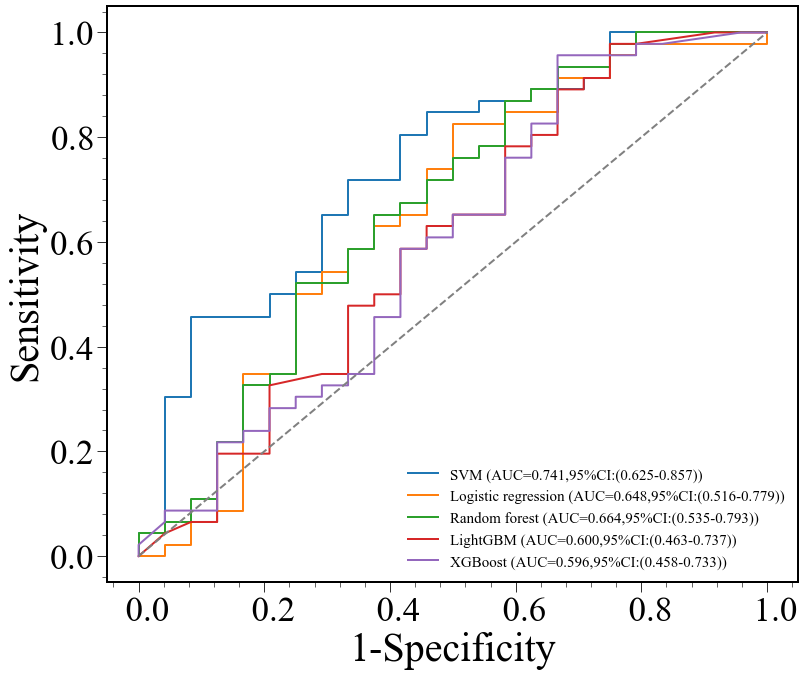

In [8]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(SSM3_KNN_true, SSM3_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM3_SVM_true, SSM3_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(SSM3_NaiveBayes_true, SSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM3_LogisticRegression_true, SSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM3_RandomForest_true, SSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM3_LightGBM_true, SSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM3_XGBoost_true, SSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('DWI',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/SSM_DWI_ROC.png", dpi=300)

#### SSM4

In [57]:
SSM4_KNN = joblib.load(os.path.join(modeldir, 'KNN_SSM4.model')) 
SSM4_KNN_pred = SSM4_KNN.predict(SSM4_test_x)
SSM4_KNN_score = SSM4_KNN.predict_proba(SSM4_test_x)
SSM4_KNN_true = SSM4_test_y  #真实标签

SSM4_SVM = joblib.load(os.path.join(modeldir, 'SVM_SSM4.model')) 
SSM4_SVM_pred = SSM4_SVM.predict(SSM4_test_x)
SSM4_SVM_score = SSM4_SVM.predict_proba(SSM4_test_x)
SSM4_SVM_true = SSM4_test_y  #真实标签

SSM4_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_SSM4.model')) 
SSM4_NaiveBayes_pred = SSM4_NaiveBayes.predict(SSM4_test_x)
SSM4_NaiveBayes_score = SSM4_NaiveBayes.predict_proba(SSM4_test_x)
SSM4_NaiveBayes_true = SSM4_test_y  #真实标签

SSM4_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_SSM4.model')) 
SSM4_LogisticRegression_pred = SSM4_LogisticRegression.predict(SSM4_test_x)
SSM4_LogisticRegression_score = SSM4_LogisticRegression.predict_proba(SSM4_test_x)
SSM4_LogisticRegression_true = SSM4_test_y  #真实标签

SSM4_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_SSM4.model')) 
SSM4_RandomForest_pred = SSM4_RandomForest.predict(SSM4_test_x)
SSM4_RandomForest_score = SSM4_RandomForest.predict_proba(SSM4_test_x)
SSM4_RandomForest_true = SSM4_test_y  #真实标签

SSM4_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_SSM4.model')) 
SSM4_LightGBM_pred = SSM4_LightGBM.predict(SSM4_test_x)
SSM4_LightGBM_score = SSM4_LightGBM.predict_proba(SSM4_test_x)
SSM4_LightGBM_true = SSM4_test_y  #真实标签

SSM4_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_SSM4.model')) 
SSM4_XGBoost_pred = SSM4_XGBoost.predict(SSM4_test_x)
SSM4_XGBoost_score = SSM4_XGBoost.predict_proba(SSM4_test_x)
SSM4_XGBoost_true = SSM4_test_y  #真实标签

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

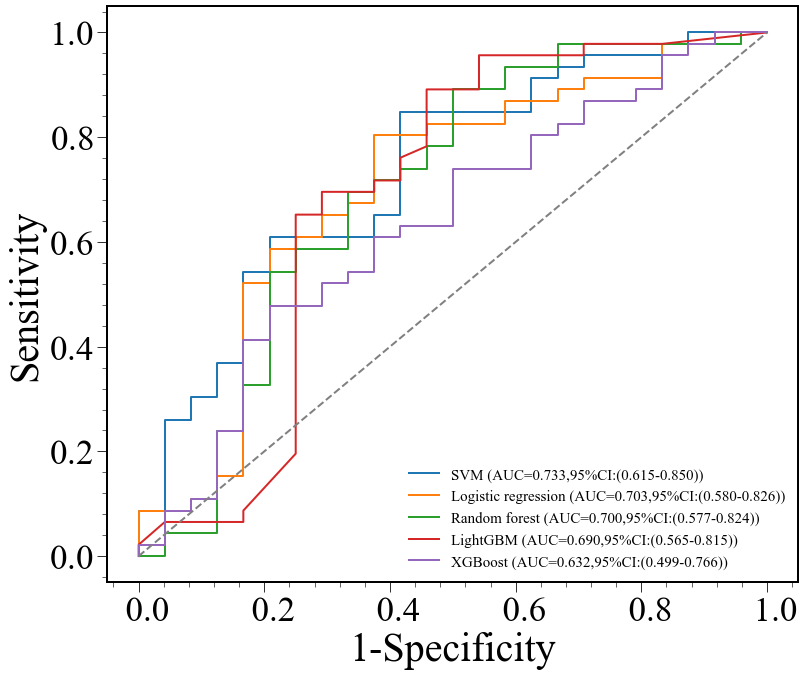

In [58]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(SSM4_KNN_true, SSM4_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(SSM4_SVM_true, SSM4_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(SSM4_NaiveBayes_true, SSM4_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(SSM4_LogisticRegression_true, SSM4_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(SSM4_RandomForest_true, SSM4_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(SSM4_LightGBM_true, SSM4_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(SSM4_XGBoost_true, SSM4_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T1CE',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/SSM_T1CE_ROC.png", dpi=300)

#### DSM3

In [59]:
DSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
DSM3_KNN_pred = DSM3_KNN.predict(DSM3_test_x)
DSM3_KNN_score = DSM3_KNN.predict_proba(DSM3_test_x)
DSM3_KNN_true = DSM3_test_y  #真实标签

DSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_DSM3.model')) 
DSM3_SVM_pred = DSM3_SVM.predict(DSM3_test_x)
DSM3_SVM_score = DSM3_SVM.predict_proba(DSM3_test_x)
DSM3_SVM_true = DSM3_test_y  #真实标签

DSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
DSM3_NaiveBayes_pred = DSM3_NaiveBayes.predict(DSM3_test_x)
DSM3_NaiveBayes_score = DSM3_NaiveBayes.predict_proba(DSM3_test_x)
DSM3_NaiveBayes_true = DSM3_test_y  #真实标签

DSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_DSM3.model')) 
DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_test_x)
DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_test_x)
DSM3_LogisticRegression_true = DSM3_test_y  #真实标签

DSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
DSM3_RandomForest_pred = DSM3_RandomForest.predict(DSM3_test_x)
DSM3_RandomForest_score = DSM3_RandomForest.predict_proba(DSM3_test_x)
DSM3_RandomForest_true = DSM3_test_y  #真实标签

DSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
DSM3_LightGBM_pred = DSM3_LightGBM.predict(DSM3_test_x)
DSM3_LightGBM_score = DSM3_LightGBM.predict_proba(DSM3_test_x)
DSM3_LightGBM_true = DSM3_test_y  #真实标签

DSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
DSM3_XGBoost_pred = DSM3_XGBoost.predict(DSM3_test_x)
DSM3_XGBoost_score = DSM3_XGBoost.predict_proba(DSM3_test_x)
DSM3_XGBoost_true = DSM3_test_y  #真实标签

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__cl

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

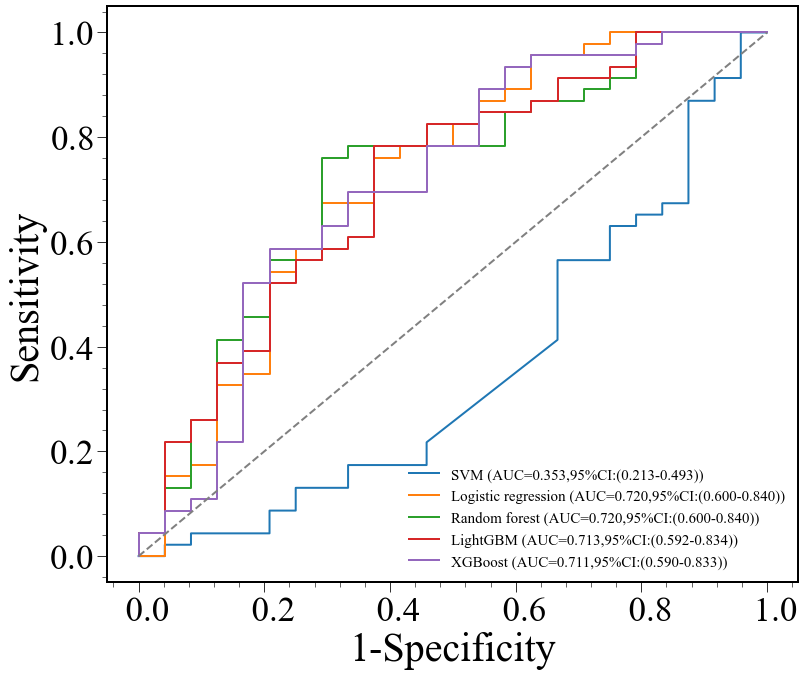

In [60]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(DSM3_KNN_true, DSM3_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(DSM3_SVM_true, DSM3_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(DSM3_NaiveBayes_true, DSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(DSM3_LogisticRegression_true, DSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(DSM3_RandomForest_true, DSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(DSM3_LightGBM_true, DSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(DSM3_XGBoost_true, DSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T2WI+T1CE',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/test_T1T2_ROC.png", dpi=300)

### Best Radiomics Results

In [61]:
Radiomics_test_true = DSM3_RandomForest_true
Radiomics_test_pred = DSM3_RandomForest_pred
Radiomics_test_score = DSM3_RandomForest_score[:,1]

#### ASM

In [62]:
ASM_KNN = joblib.load(os.path.join(modeldir, 'KNN_ASM.model')) 
ASM_KNN_pred = ASM_KNN.predict(ASM_test_x)
ASM_KNN_score = ASM_KNN.predict_proba(ASM_test_x)
ASM_KNN_true = ASM_test_y  #真实标签

ASM_SVM = joblib.load(os.path.join(modeldir, 'SVM_ASM.model')) 
ASM_SVM_pred = ASM_SVM.predict(ASM_test_x)
ASM_SVM_score = ASM_SVM.predict_proba(ASM_test_x)
ASM_SVM_true = ASM_test_y  #真实标签

ASM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_ASM.model')) 
ASM_NaiveBayes_pred = ASM_NaiveBayes.predict(ASM_test_x)
ASM_NaiveBayes_score = ASM_NaiveBayes.predict_proba(ASM_test_x)
ASM_NaiveBayes_true = ASM_test_y  #真实标签

ASM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_ASM.model')) 
ASM_LogisticRegression_pred = ASM_LogisticRegression.predict(ASM_test_x)
ASM_LogisticRegression_score = ASM_LogisticRegression.predict_proba(ASM_test_x)
ASM_LogisticRegression_true = ASM_test_y  #真实标签

ASM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_ASM.model')) 
ASM_RandomForest_pred = ASM_RandomForest.predict(ASM_test_x)
ASM_RandomForest_score = ASM_RandomForest.predict_proba(ASM_test_x)
ASM_RandomForest_true = ASM_test_y  #真实标签

ASM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_ASM.model')) 
ASM_LightGBM_pred = ASM_LightGBM.predict(ASM_test_x)
ASM_LightGBM_score = ASM_LightGBM.predict_proba(ASM_test_x)
ASM_LightGBM_true = ASM_test_y  #真实标签

ASM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_ASM.model')) 
ASM_XGBoost_pred = ASM_XGBoost.predict(ASM_test_x)
ASM_XGBoost_score = ASM_XGBoost.predict_proba(ASM_test_x)
ASM_XGBoost_true = ASM_test_y  #真实标签

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

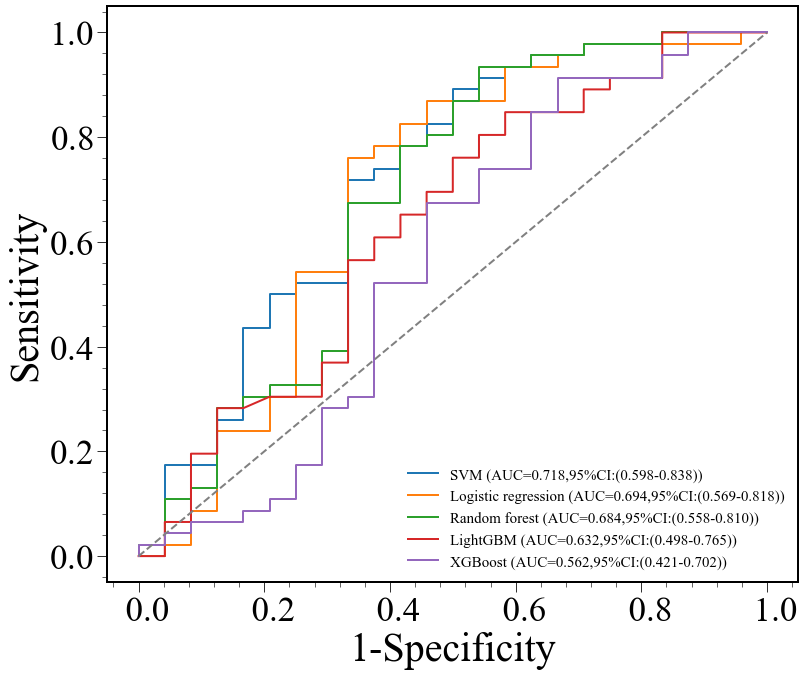

In [63]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(ASM_KNN_true, ASM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(ASM_SVM_true, ASM_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(ASM_NaiveBayes_true, ASM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(ASM_LogisticRegression_true, ASM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(ASM_RandomForest_true, ASM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(ASM_LightGBM_true, ASM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(ASM_XGBoost_true, ASM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T2WI+DWI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/test_All_ROC.png", dpi=300)

#### Clinical

In [64]:
Clinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
Clinical_KNN_pred = Clinical_KNN.predict(Clinical_test_x)
Clinical_KNN_score = Clinical_KNN.predict_proba(Clinical_test_x)
Clinical_KNN_true = Clinical_test_y  #真实标签

Clinical_SVM = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
Clinical_SVM_pred = Clinical_SVM.predict(Clinical_test_x)
Clinical_SVM_score = Clinical_SVM.predict_proba(Clinical_test_x)
Clinical_SVM_true = Clinical_test_y  #真实标签

Clinical_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
Clinical_NaiveBayes_pred = Clinical_NaiveBayes.predict(Clinical_test_x)
Clinical_NaiveBayes_score = Clinical_NaiveBayes.predict_proba(Clinical_test_x)
Clinical_NaiveBayes_true = Clinical_test_y  #真实标签

Clinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
Clinical_LogisticRegression_pred = Clinical_LogisticRegression.predict(Clinical_test_x)
Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_test_x)
Clinical_LogisticRegression_true = Clinical_test_y  #真实标签

Clinical_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
Clinical_RandomForest_pred = Clinical_RandomForest.predict(Clinical_test_x)
Clinical_RandomForest_score = Clinical_RandomForest.predict_proba(Clinical_test_x)
Clinical_RandomForest_true = Clinical_test_y  #真实标签

Clinical_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
Clinical_LightGBM_pred = Clinical_LightGBM.predict(Clinical_test_x)
Clinical_LightGBM_score = Clinical_LightGBM.predict_proba(Clinical_test_x)
Clinical_LightGBM_true = Clinical_test_y  #真实标签

Clinical_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
Clinical_XGBoost_pred = Clinical_XGBoost.predict(Clinical_test_x)
Clinical_XGBoost_score = Clinical_XGBoost.predict_proba(Clinical_test_x)
Clinical_XGBoost_true = Clinical_test_y  #真实标签

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__cl

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

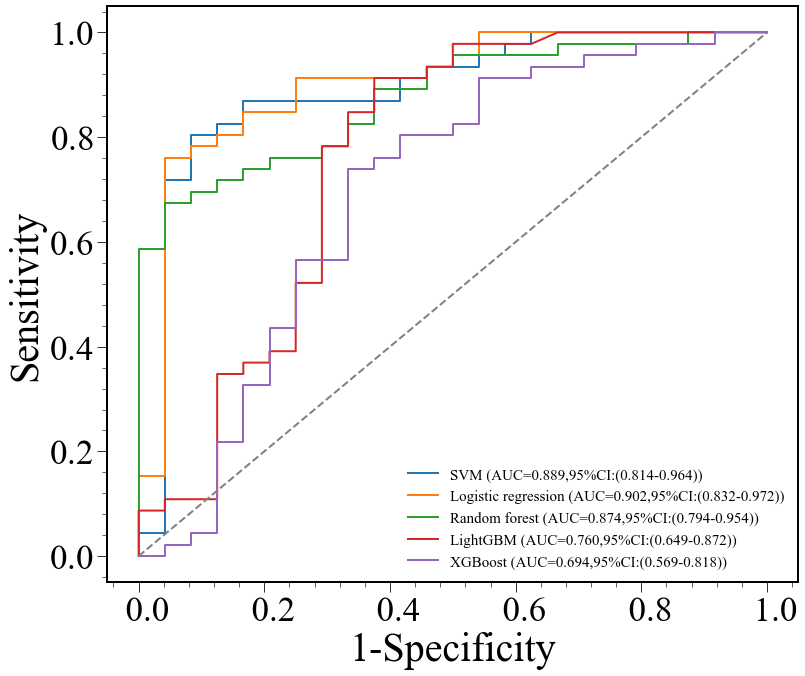

In [65]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(Clinical_KNN_true, Clinical_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(Clinical_SVM_true, Clinical_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(Clinical_NaiveBayes_true, Clinical_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(Clinical_LogisticRegression_true, Clinical_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(Clinical_RandomForest_true, Clinical_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(Clinical_LightGBM_true, Clinical_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(Clinical_XGBoost_true, Clinical_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('Clinical', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Test_Clinical_ROC.png", dpi=300)

#### Best clinical Results

In [66]:
Clinical_test_true = Clinical_LogisticRegression_true
Clinical_test_pred = Clinical_LogisticRegression_pred
Clinical_test_score = Clinical_LogisticRegression_score[:,1]

#### Clinical+T1CE+T2WI

In [67]:
CDSM_KNN = joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
CDSM_test_x = np.array([DSM3_KNN_score[:,1], Clinical_KNN_score[:, 1]]).T
CDSM_KNN_pred = CDSM_KNN.predict(CDSM_test_x)
CDSM_KNN_score = CDSM_KNN.predict_proba(CDSM_test_x)
CDSM_KNN_true = DSM3_test_y  #真实标签

CDSM_SVM = joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
CDSM_test_x = np.array([DSM3_SVM_score[:,1], Clinical_SVM_score[:, 1]]).T
CDSM_SVM_pred = CDSM_SVM.predict(CDSM_test_x)
CDSM_SVM_score = CDSM_SVM.predict_proba(CDSM_test_x)
CDSM_SVM_true = DSM3_test_y  #真实标签

CDSM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
CDSM_test_x = np.array([DSM3_NaiveBayes_score[:,1], Clinical_NaiveBayes_score[:, 1]]).T
CDSM_NaiveBayes_pred = CDSM_NaiveBayes.predict(CDSM_test_x)
CDSM_NaiveBayes_score = CDSM_NaiveBayes.predict_proba(CDSM_test_x)
CDSM_NaiveBayes_true = DSM3_test_y   #真实标签

CDSM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_CDSM.model')) 
#CDSM_test_x = np.array([DSM3_LogisticRegression_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_test_x = np.array([DSM3_RandomForest_score[:,1], Clinical_LogisticRegression_score[:, 1]]).T
CDSM_LogisticRegression_pred = CDSM_LogisticRegression.predict(CDSM_test_x)
CDSM_LogisticRegression_score = CDSM_LogisticRegression.predict_proba(CDSM_test_x)
CDSM_LogisticRegression_true = DSM3_test_y  #真实标签

CDSM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_CDSM.model')) 
CDSM_test_x = np.array([DSM3_RandomForest_score[:,1], Clinical_RandomForest_score[:, 1]]).T
CDSM_RandomForest_pred = CDSM_RandomForest.predict(CDSM_test_x)
CDSM_RandomForest_score = CDSM_RandomForest.predict_proba(CDSM_test_x)
CDSM_RandomForest_true = DSM3_test_y   #真实标签

CDSM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
CDSM_test_x = np.array([DSM3_LightGBM_score[:,1], Clinical_LightGBM_score[:, 1]]).T
CDSM_LightGBM_pred = CDSM_LightGBM.predict(CDSM_test_x)
CDSM_LightGBM_score = CDSM_LightGBM.predict_proba(CDSM_test_x)
CDSM_LightGBM_true = DSM3_test_y  #真实标签

CDSM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
CDSM_test_x = np.array([DSM3_XGBoost_score[:,1], Clinical_XGBoost_score[:, 1]]).T
CDSM_XGBoost_pred = CDSM_XGBoost.predict(CDSM_test_x)
CDSM_XGBoost_score = CDSM_XGBoost.predict_proba(CDSM_test_x)
CDSM_XGBoost_true = DSM3_test_y  #真实标签

In [68]:
CliRadio_test_x = Clinical_test_x.copy()
CliRadio_test_x['Radiomics_score'] = np.array(DSM3_RandomForest_score[:,1])
CliRadio_test_y = Clinical_test_y
CliRadio_test_x.head()
model = joblib.load(os.path.join(modeldir, 'LogisticRegression_CR.model')) 
CliRadio_test_pred = model.predict(CliRadio_test_x) #预测的标签
CliRadio_test_score = model.predict_proba(CliRadio_test_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
CliRadio_test_true = CliRadio_test_y#真实标签
eva_dic = classification_evaluation(CliRadio_test_true, CliRadio_test_pred, CliRadio_test_score[:,1])
eva_dic

,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH,Radiomics_score
0,2,1.317512,0,-0.080240,0,-0.653564,2,0,1,0.053828,0.561698
1,2,1.384848,0,-0.063505,0,-0.361334,2,2,1,1.492248,0.598037
2,3,-0.166941,0,-0.229288,0,0.324561,2,3,1,4.500577,0.594308
3,3,-0.368949,0,-0.284774,0,-0.682545,2,2,1,-0.364549,0.668554
4,2,1.565431,1,-0.050291,0,0.562451,2,3,1,1.336851,0.696076


{'accuracy': 0.9142857142857143,
 'recall': 0.8913043478260869,
 'precision': 0.9761904761904762,
 'f1': 0.9318181818181818,
 'auc': 0.9492753623188406,
 'specificity': 0.9583333333333334}

#### Best Fusion results

In [69]:
Fusion_test_true = CliRadio_test_true
Fusion_test_pred = CliRadio_test_pred
Fusion_test_score = CliRadio_test_score[:,1]

(-0.05, 1.05)

(-0.05, 1.05)

float64


Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

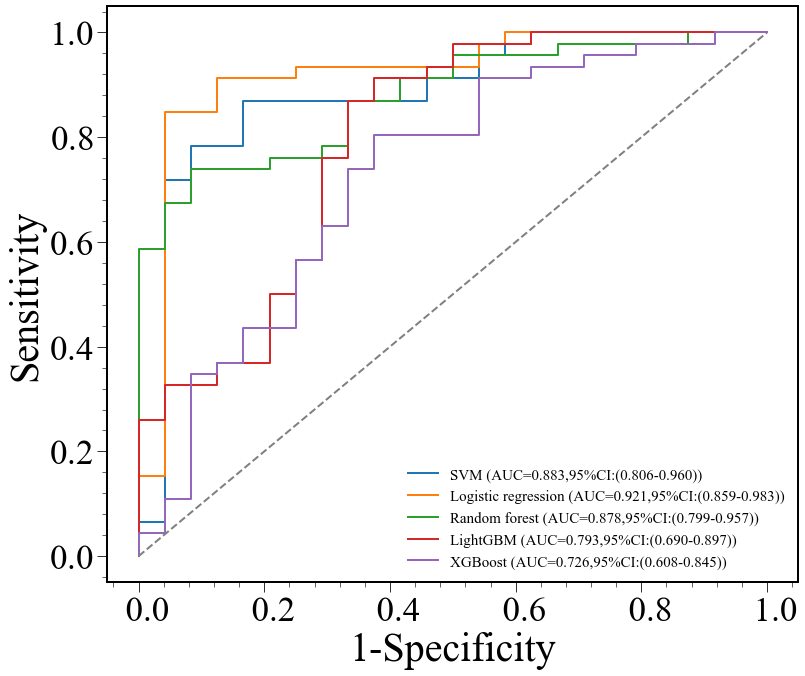

In [70]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(CDSM_KNN_true, CDSM_KNN_score[:,1], 'KNN', ax, positive=1)
print(CDSM_SVM_score.dtype)
roc_plot_inside(CDSM_SVM_true, CDSM_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(CDSM_NaiveBayes_true, CDSM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(CDSM_LogisticRegression_true, CDSM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(CDSM_RandomForest_true, CDSM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(CDSM_LightGBM_true, CDSM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(CDSM_XGBoost_true, CDSM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('Clinical+T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/test_T1T2Cli_ROC.png", dpi=300)

## External: Clinical+T1CE+T2WI

In [71]:
# DSM
exdf_DSM = pd.read_csv(os.path.join(testdir, 'DSM_test_external.csv'))
# Train data
standardscaler = StandardScaler()
# Test data
exDSM_test_y = exdf_DSM['label'] 
exDSM_test_x = exdf_DSM.drop(Dtag_cols, axis=1)
exDSM_test_x = standardscaler.fit_transform(exDSM_test_x) 
exDSM3_test_y = exDSM_test_y.to_list() 
exDSM3_test_x = exDSM_test_x

# Clinical
# Load the Clinical features.
exClinical_test = pd.read_csv(os.path.join(testdir, 'clinical_test_external.csv')) 
# Train data
standardscaler = StandardScaler()
# Test data
exClinical_test_y = exClinical_test['label']
exClinical_test_y = exClinical_test_y.to_list()
exClinical_test_x =exClinical_test.drop(Dtag_cols, axis=1)
print(exDSM3_test_y)
print(len(exClinical_test_y))
exClinical_test_x.head()
exClinical_test.head()

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]
45


,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,1,-0.849352,0,-0.289138,0,1.383446,1,1,1,-0.576757
1,1,-0.291238,0,-0.517635,0,-0.122703,1,1,0,0.339171
2,3,-0.385918,0,-0.147910,0,-0.537504,1,0,0,0.010718
3,3,0.575832,1,0.505208,0,1.796029,2,2,1,4.613389
4,2,0.939603,1,1.483008,1,-0.140448,2,3,1,0.056782


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,1,1,1,-0.849352,0,-0.289138,0,1.383446,1,1,1,-0.576757
1,2,0,1,-0.291238,0,-0.517635,0,-0.122703,1,1,0,0.339171
2,3,0,3,-0.385918,0,-0.147910,0,-0.537504,1,0,0,0.010718
3,4,1,3,0.575832,1,0.505208,0,1.796029,2,2,1,4.613389
4,5,1,2,0.939603,1,1.483008,1,-0.140448,2,3,1,0.056782


In [72]:
exDSM3_KNN = joblib.load(os.path.join(modeldir, 'KNN_DSM3.model')) 
exDSM3_KNN_pred = exDSM3_KNN.predict(exDSM3_test_x)
exDSM3_KNN_score = exDSM3_KNN.predict_proba(exDSM3_test_x)
exDSM3_KNN_true = exDSM3_test_y  #真实标签

exDSM3_SVM = joblib.load(os.path.join(modeldir, 'SVM_DSM3.model')) 
exDSM3_SVM_pred = exDSM3_SVM.predict(exDSM3_test_x)
exDSM3_SVM_score = exDSM3_SVM.predict_proba(exDSM3_test_x)
exDSM3_SVM_true = exDSM3_test_y  #真实标签

exDSM3_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_DSM3.model')) 
exDSM3_NaiveBayes_pred = exDSM3_NaiveBayes.predict(exDSM3_test_x)
exDSM3_NaiveBayes_score = exDSM3_NaiveBayes.predict_proba(exDSM3_test_x)
exDSM3_NaiveBayes_true = exDSM3_test_y  #真实标签

exDSM3_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_DSM3.model')) 
exDSM3_LogisticRegression_pred = exDSM3_LogisticRegression.predict(exDSM3_test_x)
exDSM3_LogisticRegression_score = exDSM3_LogisticRegression.predict_proba(exDSM3_test_x)
exDSM3_LogisticRegression_true = exDSM3_test_y  #真实标签

exDSM3_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_DSM3.model')) 
exDSM3_RandomForest_pred = exDSM3_RandomForest.predict(exDSM3_test_x)
exDSM3_RandomForest_score = exDSM3_RandomForest.predict_proba(exDSM3_test_x)
exDSM3_RandomForest_true = exDSM3_test_y  #真实标签

exDSM3_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_DSM3.model')) 
exDSM3_LightGBM_pred = exDSM3_LightGBM.predict(exDSM3_test_x)
exDSM3_LightGBM_score = exDSM3_LightGBM.predict_proba(exDSM3_test_x)
exDSM3_LightGBM_true = exDSM3_test_y  #真实标签

exDSM3_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_DSM3.model')) 
exDSM3_XGBoost_pred = exDSM3_XGBoost.predict(exDSM3_test_x)
exDSM3_XGBoost_score = exDSM3_XGBoost.predict_proba(exDSM3_test_x)
exDSM3_XGBoost_true = exDSM3_test_y  #真实标签
print(np.array(exDSM3_test_y))
print(np.array(exDSM3_LogisticRegression_pred))

[1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 1]
[1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0
 1 0 1 0 1 0 0 0]


/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


In [73]:
exClinical_KNN = joblib.load(os.path.join(modeldir, 'KNN_Clinical.model')) 
exClinical_KNN_pred = exClinical_KNN.predict(exClinical_test_x)
exClinical_KNN_score = exClinical_KNN.predict_proba(exClinical_test_x)
exClinical_KNN_true = exClinical_test_y  #真实标签

exClinical_SVM = joblib.load(os.path.join(modeldir, 'SVM_Clinical.model')) 
exClinical_SVM_pred = exClinical_SVM.predict(exClinical_test_x)
exClinical_SVM_score = exClinical_SVM.predict_proba(exClinical_test_x)
exClinical_SVM_true = exClinical_test_y  #真实标签

exClinical_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_Clinical.model')) 
exClinical_NaiveBayes_pred = exClinical_NaiveBayes.predict(exClinical_test_x)
exClinical_NaiveBayes_score = exClinical_NaiveBayes.predict_proba(exClinical_test_x)
exClinical_NaiveBayes_true = exClinical_test_y  #真实标签

exClinical_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_clinical.model')) 
exClinical_LogisticRegression_pred = exClinical_LogisticRegression.predict(exClinical_test_x)
exClinical_LogisticRegression_score = exClinical_LogisticRegression.predict_proba(exClinical_test_x)
exClinical_LogisticRegression_true = exClinical_test_y  #真实标签

exClinical_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_Clinical.model')) 
exClinical_RandomForest_pred = exClinical_RandomForest.predict(exClinical_test_x)
exClinical_RandomForest_score = exClinical_RandomForest.predict_proba(exClinical_test_x)
exClinical_RandomForest_true = exClinical_test_y  #真实标签

exClinical_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_Clinical.model')) 
exClinical_LightGBM_pred = exClinical_LightGBM.predict(exClinical_test_x)
exClinical_LightGBM_score = exClinical_LightGBM.predict_proba(exClinical_test_x)
exClinical_LightGBM_true = exClinical_test_y  #真实标签

exClinical_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_Clinical.model')) 
exClinical_XGBoost_pred = exClinical_XGBoost.predict(exClinical_test_x)
exClinical_XGBoost_score = exClinical_XGBoost.predict_proba(exClinical_test_x)
exClinical_XGBoost_true = exClinical_test_y  #真实标签
print(np.array(exClinical_test_y))
print(exClinical_LogisticRegression_pred)

[1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 1]
[0 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1]


/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__cl

In [74]:
eva_dic = classification_evaluation(exClinical_LogisticRegression_true, exClinical_LogisticRegression_pred, exClinical_LogisticRegression_score[:,1])
eva_dic

{'accuracy': 0.7777777777777778,
 'recall': 0.8076923076923077,
 'precision': 0.8076923076923077,
 'f1': 0.8076923076923077,
 'auc': 0.8178137651821862,
 'specificity': 0.7368421052631579}

In [75]:
exCDSM_KNN = joblib.load(os.path.join(modeldir, 'KNN_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_KNN_score[:,1], exClinical_KNN_score[:, 1]]).T
exCDSM_KNN_pred = exCDSM_KNN.predict(exCDSM_test_x)
exCDSM_KNN_score = exCDSM_KNN.predict_proba(exCDSM_test_x)
exCDSM_KNN_true = exClinical_test_y  #真实标签

exCDSM_SVM = joblib.load(os.path.join(modeldir, 'SVM_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_SVM_score[:,1], exClinical_SVM_score[:, 1]]).T
exCDSM_SVM_pred = exCDSM_SVM.predict(exCDSM_test_x)
exCDSM_SVM_score = exCDSM_SVM.predict_proba(exCDSM_test_x)
exCDSM_SVM_true = exClinical_test_y  #真实标签

exCDSM_NaiveBayes = joblib.load(os.path.join(modeldir, 'NaiveBayes_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_NaiveBayes_score[:,1], exClinical_NaiveBayes_score[:, 1]]).T
exCDSM_NaiveBayes_pred = exCDSM_NaiveBayes.predict(exCDSM_test_x)
exCDSM_NaiveBayes_score = exCDSM_NaiveBayes.predict_proba(exCDSM_test_x)
exCDSM_NaiveBayes_true = exClinical_test_y   #真实标签

exCDSM_LogisticRegression = joblib.load(os.path.join(modeldir, 'LogisticRegression_CDSM.model')) 
#exCDSM_test_x = np.array([exDSM3_LogisticRegression_score[:,1], exClinical_LogisticRegression_score[:, 1]]).T
exCDSM_test_x = np.array([exDSM3_LightGBM_score[:,1], exClinical_LogisticRegression_score[:, 1]]).T
exCDSM_LogisticRegression_pred = exCDSM_LogisticRegression.predict(exCDSM_test_x)
exCDSM_LogisticRegression_score = exCDSM_LogisticRegression.predict_proba(exCDSM_test_x)
exCDSM_LogisticRegression_true = exClinical_test_y  #真实标签

exCDSM_RandomForest = joblib.load(os.path.join(modeldir, 'RandomForest_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_RandomForest_score[:,1], exClinical_RandomForest_score[:, 1]]).T
exCDSM_RandomForest_pred = exCDSM_RandomForest.predict(exCDSM_test_x)
exCDSM_RandomForest_score = exCDSM_RandomForest.predict_proba(exCDSM_test_x)
exCDSM_RandomForest_true = exClinical_test_y   #真实标签

exCDSM_LightGBM = joblib.load(os.path.join(modeldir, 'LightGBM_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_LightGBM_score[:,1], exClinical_LightGBM_score[:, 1]]).T
exCDSM_LightGBM_pred = exCDSM_LightGBM.predict(exCDSM_test_x)
exCDSM_LightGBM_score = exCDSM_LightGBM.predict_proba(exCDSM_test_x)
exCDSM_LightGBM_true = exClinical_test_y  #真实标签

exCDSM_XGBoost = joblib.load(os.path.join(modeldir, 'XGBoost_CDSM.model')) 
exCDSM_test_x = np.array([exDSM3_XGBoost_score[:,1], exClinical_XGBoost_score[:, 1]]).T
exCDSM_XGBoost_pred = exCDSM_XGBoost.predict(exCDSM_test_x)
exCDSM_XGBoost_score = exCDSM_XGBoost.predict_proba(exCDSM_test_x)
exCDSM_XGBoost_true = exClinical_test_y  #真实标签
print(np.array(exClinical_test_y))
print(np.array(exCDSM_LogisticRegression_pred))

[1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 0 0 0 0 1 1]
[1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0
 1 0 0 0 1 1 0 1]


In [76]:
CliRadio_extest_x = exClinical_test_x.copy()
len(CliRadio_extest_x)
CliRadio_extest_x['Radiomics_score'] = np.array(exDSM3_LogisticRegression_score[:,1])
CliRadio_extest_y = exClinical_test_y
DSM3_test_x.head()

model= joblib.load(os.path.join(modeldir, 'LogisticRegression_CR.model')) 
CliRadio_extest_pred = model.predict(CliRadio_extest_x)#, probability=True) #预测的标签
CliRadio_extest_score = model.predict_proba(CliRadio_extest_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
CliRadio_extest_true = CliRadio_extest_y#真实标签
eva_dic = classification_evaluation(CliRadio_extest_true, CliRadio_extest_pred, CliRadio_extest_score[:,1])
eva_dic

45

,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
0,0.797085,0.592704,-0.557901,-0.668887,-0.923962,-0.042202,0.362689
1,0.710836,0.190043,-0.354496,0.938193,-0.438992,0.703784,0.044257
2,0.611513,-1.768737,-0.476457,2.215376,-1.323789,0.271287,-1.020230
3,-1.189034,1.285826,-0.943225,-0.708169,-2.687189,0.753846,0.516276
4,0.421419,-0.341289,-0.725443,-0.688572,0.037356,0.591782,0.882457


{'accuracy': 0.7777777777777778,
 'recall': 0.8076923076923077,
 'precision': 0.8076923076923077,
 'f1': 0.8076923076923077,
 'auc': 0.8340080971659919,
 'specificity': 0.7368421052631579}

### Best Radiomics external results

In [77]:
Radiomics_extest_true = exDSM3_RandomForest_true 
Radiomics_extest_pred = exDSM3_RandomForest_pred
Radiomics_extest_score = exDSM3_RandomForest_score[:,1]

### Best Clinical external results

In [78]:
Clinical_extest_true = exClinical_LogisticRegression_true
Clinical_extest_pred = exClinical_LogisticRegression_pred
Clinical_extest_score = exClinical_LogisticRegression_score[:,1]

### Best Fusion external results

In [79]:
Fusion_extest_true = CliRadio_extest_true
Fusion_extest_pred = CliRadio_extest_pred
Fusion_extest_score = CliRadio_extest_score[:,1]

(-0.05, 1.05)

(-0.05, 1.05)

[0.47720722 0.51251057 0.50579951 0.4930373  0.51497093 0.50565202
 0.5        0.47026609 0.47772876 0.5        0.47725194 0.48921673
 0.49405908 0.50899406 0.5        0.53465402 0.51269814 0.5
 0.49012089 0.5        0.48859173 0.48757294 0.51511745 0.49091292
 0.51701813 0.49452122 0.48193526 0.50733362 0.48396954 0.5
 0.47856687 0.49288519 0.52978613 0.4831804  0.4843556  0.49205782
 0.5        0.48670638 0.50853023 0.5        0.508095   0.49336922
 0.50617133 0.51260978 0.50673739]
[1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]


45

45

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

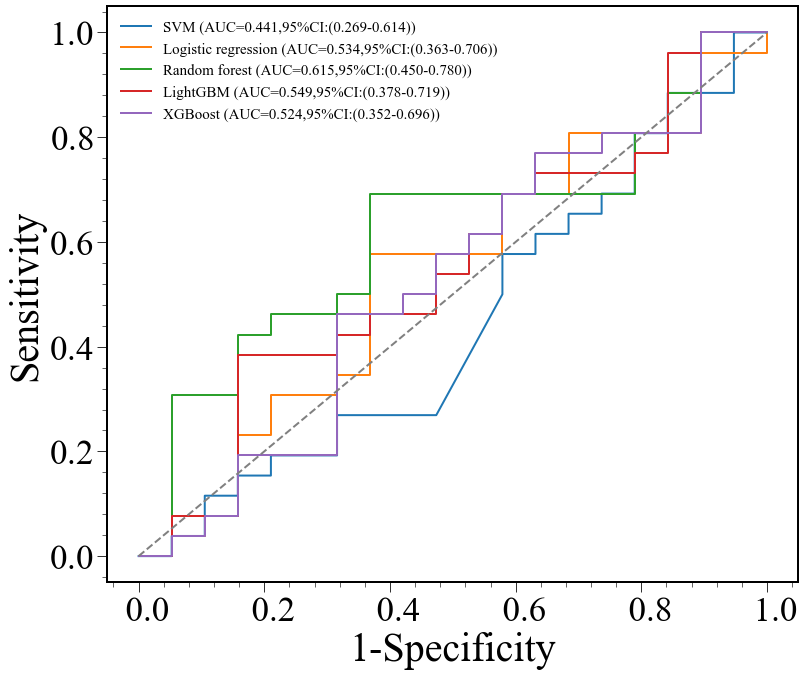

In [80]:
plt.clf()
fig = plt.figure(figsize=(12,10))

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(exDSM3_KNN_true, exDSM3_KNN_score[:,1], 'KNN', ax, positive=1)
print(exDSM3_SVM_score[:,1])
print(exDSM3_SVM_true)
len(exDSM3_SVM_score)
len(exDSM3_SVM_true)
roc_plot_inside(exDSM3_SVM_true, exDSM3_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(exDSM3_NaiveBayes_true, exDSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(exDSM3_LogisticRegression_true, exDSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(exDSM3_RandomForest_true, exDSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(exDSM3_LightGBM_true, exDSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(exDSM3_XGBoost_true, exDSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('External test: T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/external_T1T2_ROC.png", dpi=300)

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

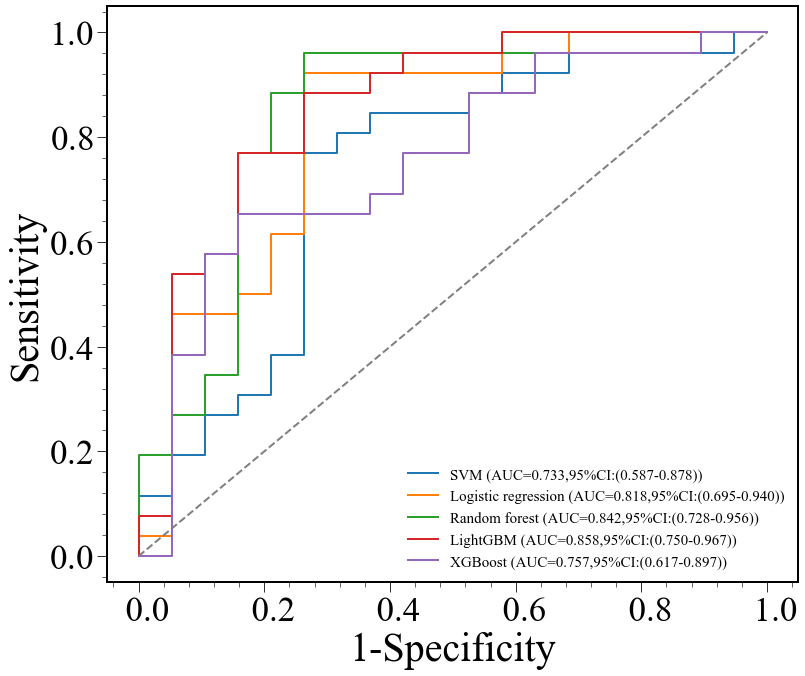

In [81]:
plt.clf()
fig = plt.figure(figsize=(12,10))

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

#roc_plot_inside(exClinical_KNN_true, exClinical_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(exClinical_SVM_true, exClinical_SVM_score[:,1], 'SVM', ax, positive=1)
#roc_plot_inside(exClinical_NaiveBayes_true, exClinical_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(exClinical_LogisticRegression_true, exClinical_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(exClinical_RandomForest_true, exClinical_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(exClinical_LightGBM_true, exClinical_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(exClinical_XGBoost_true, exClinical_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
#ax.set_title('External test: Clinical+T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/external_T1T2Cli_ROC.png", dpi=300)

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

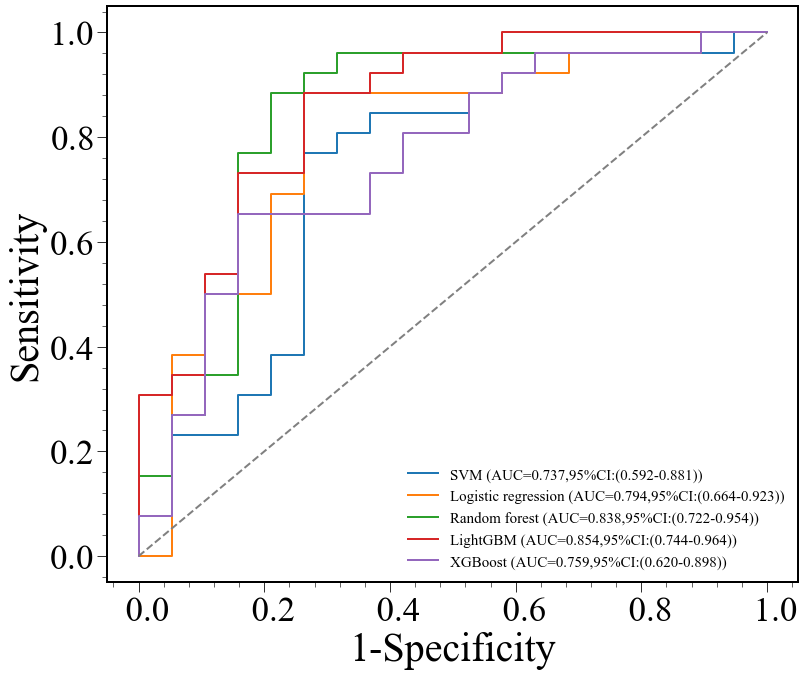

In [82]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(exCDSM_KNN_true, exCDSM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(exCDSM_SVM_true, exCDSM_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(exCDSM_NaiveBayes_true, exCDSM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(exCDSM_LogisticRegression_true, exCDSM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(exCDSM_RandomForest_true, exCDSM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(exCDSM_LightGBM_true, exCDSM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(exCDSM_XGBoost_true, exCDSM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('External test: Clinical+radiological', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/external_Clinical_ROC.png", dpi=300)

## Train results

In [83]:
cwd = os.getcwd()
traindir = '../Feature_filter/Feas_data'
imgdir = os.path.join(cwd, 'IMG')
modeldir = os.path.join(cwd, 'Model')
tag_cols = ['pid', 'label', 'series','image', 'mask']
sequence_id = [2, 3, 4]
# Generate the random seed
random_state = random.randint(1,10000)

SSM_train_slist = [pd.read_excel(os.path.join(traindir, 'feas_mrmr_sel.xlsx'), sheet_name=f'sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# train data
SSM_train_y = [df['label'] for df in SSM_train_slist]
SSM_train_x = [df.drop(tag_cols, axis=1) for df in SSM_train_slist]

SSM2_train_y, SSM3_train_y, SSM4_train_y = (y_.to_list() for y_ in SSM_train_y)
SSM2_train_x, SSM3_train_x, SSM4_train_x = (x_ for x_ in SSM_train_x)

# DSM
Dtag_cols = ['pid', 'label']
DSM_train_slist = [pd.read_excel(os.path.join(traindir, 'DSM_feas_mrmr_sel.xlsx'), sheet_name=f'no_sequence{num}') for num in sequence_id]
# Train data
standardscaler = StandardScaler()
# train data
DSM_train_y = [df['label'] for df in DSM_train_slist]
DSM_train_x = [df.drop(Dtag_cols, axis=1) for df in DSM_train_slist]
DSM2_train_y, DSM3_train_y, DSM4_train_y = (y_.to_list() for y_ in DSM_train_y)
DSM2_train_x, DSM3_train_x, DSM4_train_x = (x_ for x_ in DSM_train_x)

# ASM
Atag_cols = ['pid', 'label']
ASM_train = pd.read_csv(os.path.join(traindir, 'ASM_mrmr_feas.csv')) 
# Train data
standardscaler = StandardScaler()
# train data
ASM_train_y = ASM_train['label']
ASM_train_x =ASM_train.drop(Dtag_cols, axis=1)

# Clinical
# Load the Clinical features.
Atag_cols = ['pid', 'label']
Clinical_train = pd.read_csv(os.path.join(traindir, 'clinical_lasso_sel.csv')) 
# Train data
standardscaler = StandardScaler()
# train data
Clinical_train_y = Clinical_train['label']
Clinical_train_x = Clinical_train.drop(Dtag_cols, axis=1)
DSM_train_slist[1].head()

,pid,label,glszm_SmallAreaEmphasis_logarithm2,glcm_InverseVariance_exponential2,glrlm_ShortRunLowGrayLevelEmphasis_square4,glszm_GrayLevelNonUniformity_wavelet-HHH2,glcm_Correlation_log-sigma-3-0-mm-3D2,glszm_ZoneEntropy_exponential4,firstorder_Skewness_logarithm2
0,1,0,1.447081,0.757814,-0.452265,0.494983,-1.011382,0.919693,-0.307427
1,2,1,-0.145508,-1.298190,-0.190610,-0.276422,-0.294524,0.616358,1.332940
2,3,1,0.691198,-0.340941,-0.438346,-0.121146,-0.288731,-1.451869,0.788919
3,4,0,0.542103,1.250093,-0.725200,0.342291,-0.524326,0.675756,0.528886
4,8,1,-0.124139,0.967292,-0.238149,-0.411194,-0.570905,0.180514,1.294495


In [84]:
train_SSM2_KNN_pred = SSM2_KNN.predict(SSM2_train_x)
train_SSM2_KNN_score = SSM2_KNN.predict_proba(SSM2_train_x)
train_SSM2_KNN_true = SSM2_train_y  #真实标签

train_SSM2_SVM_pred = SSM2_SVM.predict(SSM2_train_x)
train_SSM2_SVM_score = SSM2_SVM.predict_proba(SSM2_train_x)
train_SSM2_SVM_true = SSM2_train_y  #真实标签

train_SSM2_NaiveBayes_pred = SSM2_NaiveBayes.predict(SSM2_train_x)
train_SSM2_NaiveBayes_score = SSM2_NaiveBayes.predict_proba(SSM2_train_x)
train_SSM2_NaiveBayes_true = SSM2_train_y  #真实标签

train_SSM2_LogisticRegression_pred = SSM2_LogisticRegression.predict(SSM2_train_x)
train_SSM2_LogisticRegression_score = SSM2_LogisticRegression.predict_proba(SSM2_train_x)
train_SSM2_LogisticRegression_true = SSM2_train_y  #真实标签

train_SSM2_RandomForest_pred = SSM2_RandomForest.predict(SSM2_train_x)
train_SSM2_RandomForest_score = SSM2_RandomForest.predict_proba(SSM2_train_x)
train_SSM2_RandomForest_true = SSM2_train_y  #真实标签

train_SSM2_LightGBM_pred = SSM2_LightGBM.predict(SSM2_train_x)
train_SSM2_LightGBM_score = SSM2_LightGBM.predict_proba(SSM2_train_x)
train_SSM2_LightGBM_true = SSM2_train_y  #真实标签

train_SSM2_XGBoost_pred = SSM2_XGBoost.predict(SSM2_train_x)
train_SSM2_XGBoost_score = SSM2_XGBoost.predict_proba(SSM2_train_x)
train_SSM2_XGBoost_true = SSM2_train_y  #真实标签

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

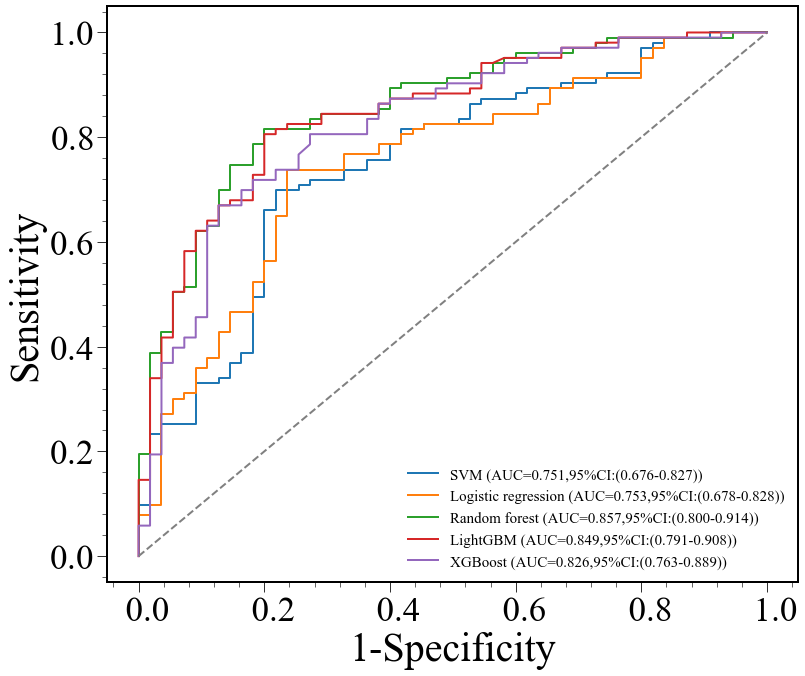

In [85]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_SSM2_KNN_true, train_SSM2_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(train_SSM2_SVM_true, train_SSM2_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(train_SSM2_NaiveBayes_true, train_SSM2_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(train_SSM2_LogisticRegression_true, train_SSM2_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(train_SSM2_RandomForest_true, train_SSM2_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(train_SSM2_LightGBM_true, train_SSM2_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(train_SSM2_XGBoost_true, train_SSM2_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T2WI', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/train_T2WI_ROC.png", dpi=300)

#### DSM3

In [86]:
train_DSM3_KNN_pred = DSM3_KNN.predict(DSM3_train_x)
train_DSM3_KNN_score = DSM3_KNN.predict_proba(DSM3_train_x)
train_DSM3_KNN_true = DSM3_train_y  #真实标签

train_DSM3_SVM_pred = DSM3_SVM.predict(DSM3_train_x)
train_DSM3_SVM_score = DSM3_SVM.predict_proba(DSM3_train_x)
train_DSM3_SVM_true = DSM3_train_y  #真实标签

train_DSM3_NaiveBayes_pred = DSM3_NaiveBayes.predict(DSM3_train_x)
train_DSM3_NaiveBayes_score = DSM3_NaiveBayes.predict_proba(DSM3_train_x)
train_DSM3_NaiveBayes_true = DSM3_train_y  #真实标签

train_DSM3_LogisticRegression_pred = DSM3_LogisticRegression.predict(DSM3_train_x)
train_DSM3_LogisticRegression_score = DSM3_LogisticRegression.predict_proba(DSM3_train_x)
train_DSM3_LogisticRegression_true = DSM3_train_y  #真实标签

train_DSM3_RandomForest_pred = DSM3_RandomForest.predict(DSM3_train_x)
train_DSM3_RandomForest_score = DSM3_RandomForest.predict_proba(DSM3_train_x)
train_DSM3_RandomForest_true = DSM3_train_y  #真实标签

train_DSM3_LightGBM_pred = DSM3_LightGBM.predict(DSM3_train_x)
train_DSM3_LightGBM_score = DSM3_LightGBM.predict_proba(DSM3_train_x)
train_DSM3_LightGBM_true = DSM3_train_y  #真实标签

train_DSM3_XGBoost_pred = DSM3_XGBoost.predict(DSM3_train_x)
train_DSM3_XGBoost_score = DSM3_XGBoost.predict_proba(DSM3_train_x)
train_DSM3_XGBoost_true = DSM3_train_y  #真实标签

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__cl

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

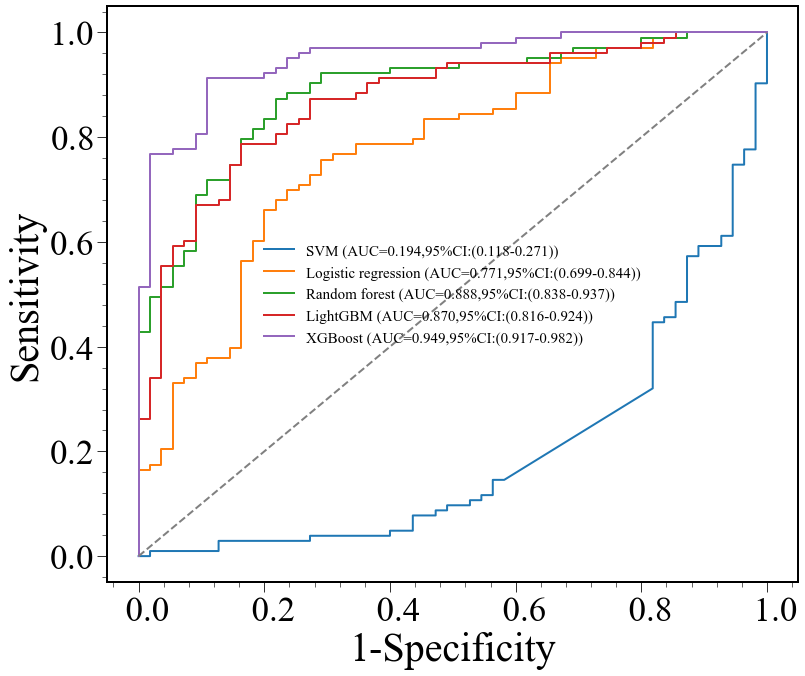

In [87]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_DSM3_KNN_true, train_DSM3_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(train_DSM3_SVM_true, train_DSM3_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(train_DSM3_NaiveBayes_true, train_DSM3_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(train_DSM3_LogisticRegression_true, train_DSM3_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(train_DSM3_RandomForest_true, train_DSM3_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(train_DSM3_LightGBM_true, train_DSM3_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(train_DSM3_XGBoost_true, train_DSM3_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('T2WI+T1CE',fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_T1T2_ROC.png", dpi=300)

#### Best Radiomics train results

In [88]:
Radiomics_train_true = train_DSM3_RandomForest_true
Radiomics_train_pred = train_DSM3_RandomForest_pred
Radiomics_train_score = train_DSM3_RandomForest_score[:,1]

#### Clinical

In [89]:
train_Clinical_KNN_pred = Clinical_KNN.predict(Clinical_train_x)
train_Clinical_KNN_score = Clinical_KNN.predict_proba(Clinical_train_x)
train_Clinical_KNN_true = Clinical_train_y  #真实标签

train_Clinical_SVM_pred = Clinical_SVM.predict(Clinical_train_x)
train_Clinical_SVM_score = Clinical_SVM.predict_proba(Clinical_train_x)
train_Clinical_SVM_true = Clinical_train_y  #真实标签

train_Clinical_NaiveBayes_pred = Clinical_NaiveBayes.predict(Clinical_train_x)
train_Clinical_NaiveBayes_score = Clinical_NaiveBayes.predict_proba(Clinical_train_x)
train_Clinical_NaiveBayes_true = Clinical_train_y  #真实标签

train_Clinical_LogisticRegression_pred = Clinical_LogisticRegression.predict(Clinical_train_x)
train_Clinical_LogisticRegression_score = Clinical_LogisticRegression.predict_proba(Clinical_train_x)
train_Clinical_LogisticRegression_true = Clinical_train_y  #真实标签

train_Clinical_RandomForest_pred = Clinical_RandomForest.predict(Clinical_train_x)
train_Clinical_RandomForest_score = Clinical_RandomForest.predict_proba(Clinical_train_x)
train_Clinical_RandomForest_true = Clinical_train_y  #真实标签

train_Clinical_LightGBM_pred = Clinical_LightGBM.predict(Clinical_train_x)
train_Clinical_LightGBM_score = Clinical_LightGBM.predict_proba(Clinical_train_x)
train_Clinical_LightGBM_true = Clinical_train_y  #真实标签

train_Clinical_XGBoost_pred = Clinical_XGBoost.predict(Clinical_train_x)
train_Clinical_XGBoost_score = Clinical_XGBoost.predict_proba(Clinical_train_x)
train_Clinical_XGBoost_true = Clinical_train_y  #真实标签

/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/media/tx-deepocean/Data/TX_wrapperenv/chongfu1/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__cl

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

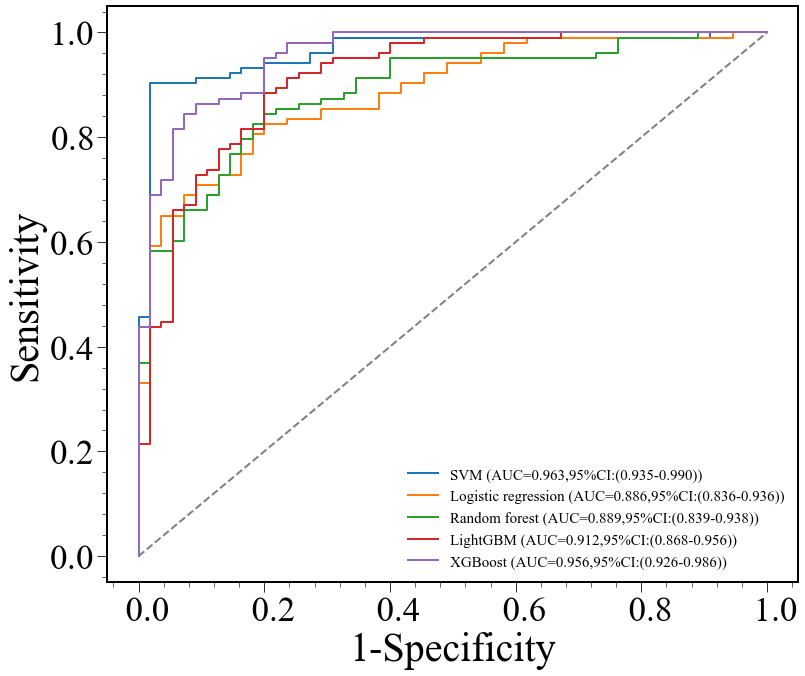

In [90]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_Clinical_KNN_true, train_Clinical_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(train_Clinical_SVM_true, train_Clinical_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(train_Clinical_NaiveBayes_true, train_Clinical_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(train_Clinical_LogisticRegression_true, train_Clinical_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(train_Clinical_RandomForest_true, train_Clinical_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(train_Clinical_LightGBM_true, train_Clinical_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(train_Clinical_XGBoost_true, train_Clinical_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('Clinical', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Train_Clinical_ROC.png", dpi=300)

#### Best clinical train Results

In [91]:
Clinical_train_true = train_Clinical_LogisticRegression_true
Clinical_train_pred = train_Clinical_LogisticRegression_pred
Clinical_train_score = train_Clinical_LogisticRegression_score[:,1]

#### Clinical+T1CE+T2WI

In [92]:
CDSM_train_x = np.array([train_DSM3_KNN_score[:,1], train_Clinical_KNN_score[:, 1]]).T
train_CDSM_KNN_pred = CDSM_KNN.predict(CDSM_train_x)
train_CDSM_KNN_score = CDSM_KNN.predict_proba(CDSM_train_x)
train_CDSM_KNN_true = DSM3_train_y  #真实标签

CDSM_train_x = np.array([train_DSM3_SVM_score[:,1], train_Clinical_SVM_score[:, 1]]).T
train_CDSM_SVM_pred = CDSM_SVM.predict(CDSM_train_x)
train_CDSM_SVM_score = CDSM_SVM.predict_proba(CDSM_train_x)
train_CDSM_SVM_true = DSM3_train_y  #真实标签

CDSM_train_x = np.array([train_DSM3_NaiveBayes_score[:,1], train_Clinical_NaiveBayes_score[:, 1]]).T
train_CDSM_NaiveBayes_pred = CDSM_NaiveBayes.predict(CDSM_train_x)
train_CDSM_NaiveBayes_score = CDSM_NaiveBayes.predict_proba(CDSM_train_x)
train_CDSM_NaiveBayes_true = DSM3_train_y   #真实标签

CDSM_train_x = np.array([train_DSM3_LogisticRegression_score[:,1], train_Clinical_LogisticRegression_score[:, 1]]).T
train_CDSM_LogisticRegression_pred = CDSM_LogisticRegression.predict(CDSM_train_x)
train_CDSM_LogisticRegression_score = CDSM_LogisticRegression.predict_proba(CDSM_train_x)
train_CDSM_LogisticRegression_true = DSM3_train_y  #真实标签

CDSM_train_x = np.array([train_DSM3_RandomForest_score[:,1], train_Clinical_RandomForest_score[:, 1]]).T
train_CDSM_RandomForest_pred = CDSM_RandomForest.predict(CDSM_train_x)
train_CDSM_RandomForest_score = CDSM_RandomForest.predict_proba(CDSM_train_x)
train_CDSM_RandomForest_true = DSM3_train_y   #真实标签

CDSM_train_x = np.array([train_DSM3_LightGBM_score[:,1], train_Clinical_LightGBM_score[:, 1]]).T
train_CDSM_LightGBM_pred = CDSM_LightGBM.predict(CDSM_train_x)
train_CDSM_LightGBM_score = CDSM_LightGBM.predict_proba(CDSM_train_x)
train_CDSM_LightGBM_true = DSM3_train_y  #真实标签

CDSM_train_x = np.array([train_DSM3_XGBoost_score[:,1], train_Clinical_XGBoost_score[:, 1]]).T
train_CDSM_XGBoost_pred = CDSM_XGBoost.predict(CDSM_train_x)
train_CDSM_XGBoost_score = CDSM_XGBoost.predict_proba(CDSM_train_x)
train_CDSM_XGBoost_true = DSM3_train_y  #真实标签

In [93]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
CliRadio_train_x = Clinical_train_x.copy()
len(CliRadio_train_x)
CliRadio_train_x.head()
CliRadio_train_x['Radiomics_score'] = np.array(train_DSM3_RandomForest_score[:,1])
CliRadio_train_y = Clinical_train_y

smote = SMOTE(k_neighbors=2, random_state=42)
tl = TomekLinks()
X_smote, Y_smote = tl.fit_resample(CliRadio_train_x, CliRadio_train_y)
X_smote, Y_smote = tl.fit_resample(X_smote, Y_smote)
# X_smote, Y_smote = smote.fit_resample(X_smote, Y_smote)
CliRadio_train_x, CliRadio_train_y = X_smote, Y_smote

model= joblib.load(os.path.join(modeldir, 'LogisticRegression_CR.model')) 
CliRadio_train_pred = model.predict(CliRadio_train_x)#, probability=True) #预测的标签
CliRadio_train_score = model.predict_proba(CliRadio_train_x)#得到标签0 (y_predict[:,0])和1 (y_predict[:,1])对应的概率
CliRadio_train_true = CliRadio_train_y#真实标签
eva_dic = classification_evaluation(CliRadio_train_true, CliRadio_train_pred, CliRadio_train_score[:,1])
eva_dic

158

,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,3,-0.979298,0,-0.619137,0,-0.567482,1,0,0,-0.493932
1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683
2,3,-0.368746,0,0.381479,0,-0.360563,1,2,0,-0.258967
3,3,2.825204,0,-0.398053,0,-0.071242,1,3,0,0.956370
4,3,1.657523,0,0.425421,0,-0.221396,2,3,1,-0.372399


{'accuracy': 0.8657718120805369,
 'recall': 0.8617021276595744,
 'precision': 0.9204545454545454,
 'f1': 0.8901098901098901,
 'auc': 0.9551257253384913,
 'specificity': 0.8727272727272727}

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

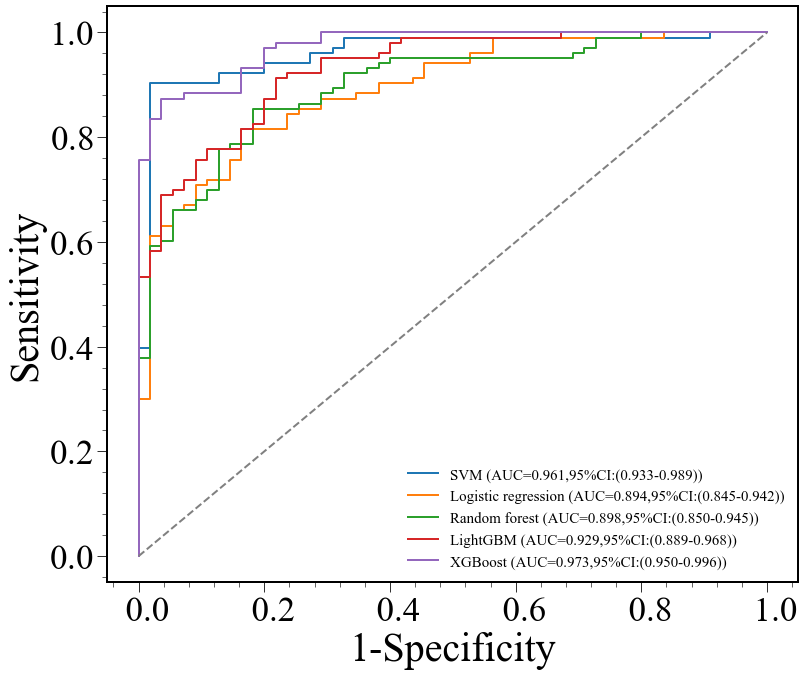

In [94]:
plt.clf()
fig = plt.figure()

# Set offset for margin
left, bottom, width, height = 0.15, 0.15, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_CDSM_KNN_true, train_CDSM_KNN_score[:,1], 'KNN', ax, positive=1)
roc_plot_inside(train_CDSM_SVM_true, train_CDSM_SVM_score[:,1], 'SVM', ax, positive=1)
# roc_plot_inside(train_CDSM_NaiveBayes_true, train_CDSM_NaiveBayes_score[:,1], 'NaiveBayes', ax, positive=1)
roc_plot_inside(train_CDSM_LogisticRegression_true, train_CDSM_LogisticRegression_score[:,1], 'Logistic regression', ax, positive=1)
roc_plot_inside(train_CDSM_RandomForest_true, train_CDSM_RandomForest_score[:,1], 'Random forest', ax, positive=1)
roc_plot_inside(train_CDSM_LightGBM_true, train_CDSM_LightGBM_score[:,1], 'LightGBM', ax, positive=1)
roc_plot_inside(train_CDSM_XGBoost_true, train_CDSM_XGBoost_score[:,1], 'XGBoost', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
# ax.set_title('Clinical+T2WI+T1CE', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/train_T1T2Cli_ROC.png", dpi=300)

### Best Fusion train results

In [95]:
Fusion_train_true = CliRadio_train_true
Fusion_train_pred = CliRadio_train_pred
Fusion_train_score = CliRadio_train_score[:,1]

## Results Evaluation

In [96]:
# Radiomics
classification_evaluation(Radiomics_train_true, Radiomics_train_pred, Radiomics_train_score)
classification_evaluation(Radiomics_test_true, Radiomics_test_pred, Radiomics_test_score)
classification_evaluation(Radiomics_extest_true, Radiomics_extest_pred, Radiomics_extest_score)

{'accuracy': 0.8164556962025317,
 'recall': 0.8349514563106796,
 'precision': 0.8775510204081632,
 'f1': 0.8557213930348259,
 'auc': 0.8875551632833187,
 'specificity': 0.7818181818181819}

{'accuracy': 0.6857142857142857,
 'recall': 0.782608695652174,
 'precision': 0.75,
 'f1': 0.7659574468085107,
 'auc': 0.720108695652174,
 'specificity': 0.5}

{'accuracy': 0.6444444444444445,
 'recall': 0.6923076923076923,
 'precision': 0.6923076923076923,
 'f1': 0.6923076923076923,
 'auc': 0.6153846153846154,
 'specificity': 0.5789473684210527}

In [112]:
# Clinical
classification_evaluation(Clinical_train_true, Clinical_train_pred, Clinical_train_score)
classification_evaluation(Clinical_test_true, Clinical_test_pred, Clinical_test_score)
classification_evaluation(Clinical_extest_true, Clinical_extest_pred, Clinical_extest_score)
Clinical_extest_pred1 = Clinical_extest_pred.copy()
Clinical_extest_pred1[-1] = 1-Clinical_extest_pred1[-1]
# Clinical_extest_pred1[-5] = 1-Clinical_extest_pred1[-5]
classification_evaluation(Clinical_extest_true, Clinical_extest_pred1, Clinical_extest_score)

{'accuracy': 0.8037974683544303,
 'recall': 0.7961165048543689,
 'precision': 0.8913043478260869,
 'f1': 0.8410256410256409,
 'auc': 0.8861429832303619,
 'specificity': 0.8181818181818182}

{'accuracy': 0.8428571428571429,
 'recall': 0.8478260869565217,
 'precision': 0.9069767441860465,
 'f1': 0.8764044943820224,
 'auc': 0.9021739130434783,
 'specificity': 0.8333333333333334}

{'accuracy': 0.7777777777777778,
 'recall': 0.8076923076923077,
 'precision': 0.8076923076923077,
 'f1': 0.8076923076923077,
 'auc': 0.8178137651821862,
 'specificity': 0.7368421052631579}

{'accuracy': 0.7555555555555555,
 'recall': 0.7692307692307693,
 'precision': 0.8,
 'f1': 0.7843137254901961,
 'auc': 0.8178137651821862,
 'specificity': 0.7368421052631579}

In [99]:
# Fusion
classification_evaluation(Fusion_train_true, Fusion_train_pred, Fusion_train_score)
classification_evaluation(Fusion_test_true, Fusion_test_pred, Fusion_test_score)
classification_evaluation(Fusion_extest_true, Fusion_extest_pred, Fusion_extest_score)
# Fusion_extest_true = , Fusion_extest_pred, Fusion_extest_score)

{'accuracy': 0.8657718120805369,
 'recall': 0.8617021276595744,
 'precision': 0.9204545454545454,
 'f1': 0.8901098901098901,
 'auc': 0.9551257253384913,
 'specificity': 0.8727272727272727}

{'accuracy': 0.9142857142857143,
 'recall': 0.8913043478260869,
 'precision': 0.9761904761904762,
 'f1': 0.9318181818181818,
 'auc': 0.9492753623188406,
 'specificity': 0.9583333333333334}

{'accuracy': 0.7777777777777778,
 'recall': 0.8076923076923077,
 'precision': 0.8076923076923077,
 'f1': 0.8076923076923077,
 'auc': 0.8340080971659919,
 'specificity': 0.7368421052631579}

## Confusion Matrix for fusion model

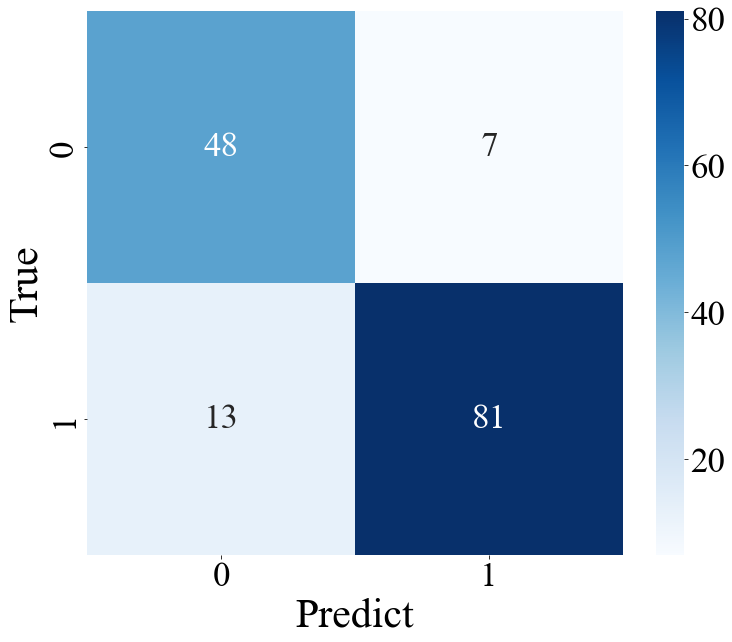

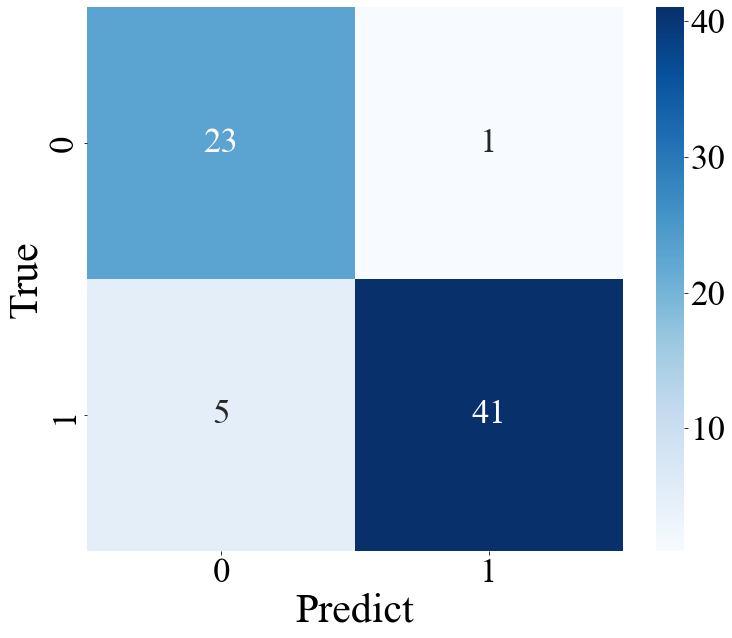

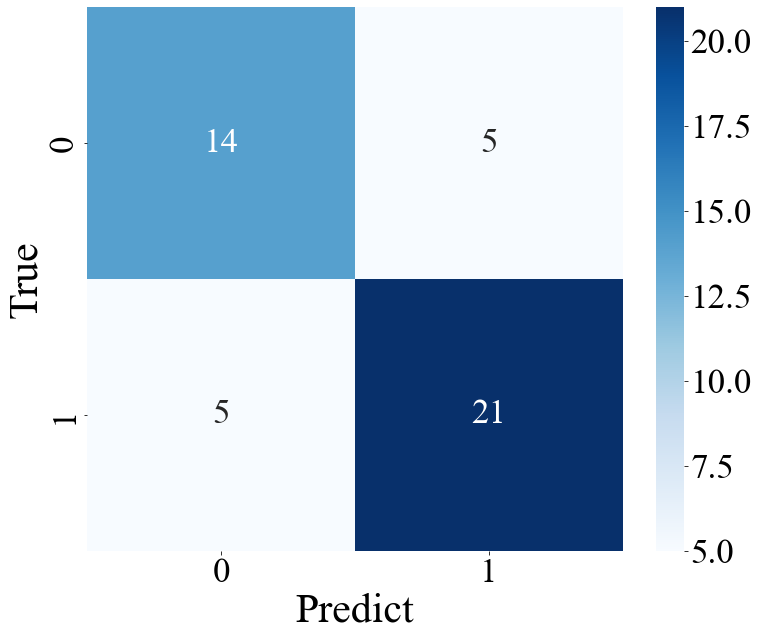

In [151]:
confusion_matrix_plot(Fusion_train_true, Fusion_train_pred, './IMG/Fusion_train_CM.png')
confusion_matrix_plot(Fusion_test_true, Fusion_test_pred, './IMG/Fusion_test_CM.png')
confusion_matrix_plot(Fusion_extest_true, Fusion_extest_pred, './IMG/Fusion_extest_CM.png')

#### Train, validation, test

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

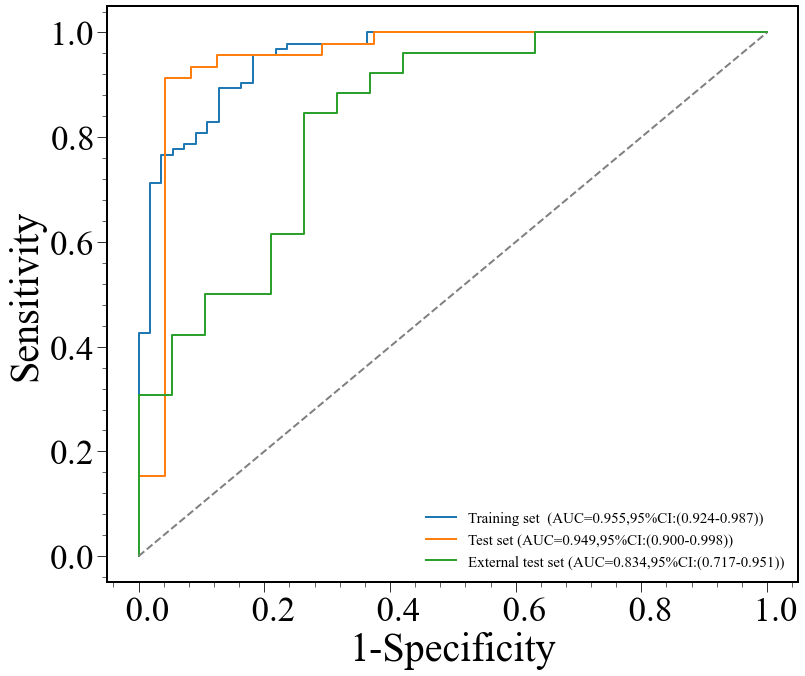

In [138]:
plt.clf()
fig = plt.figure(figsize=(12,10))

# Set offset for margin
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_CDSM_XGBoost_true, train_CDSM_XGBoost_score[:,1], 'Train set', ax, positive=1)
roc_plot_inside(CliRadio_train_true, CliRadio_train_score[:,1], 'Training set ', ax, positive=1)
roc_plot_inside(CliRadio_test_true, CliRadio_test_score[:,1], 'Test set', ax, positive=1)
roc_plot_inside(CliRadio_extest_true, CliRadio_extest_score[:,1], 'External test set', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
#ax.set_title('Clinical+Radiological+Radiomics', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/train_validation_test.png", dpi=300, bbox_inches='tight')

#### Internal test

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

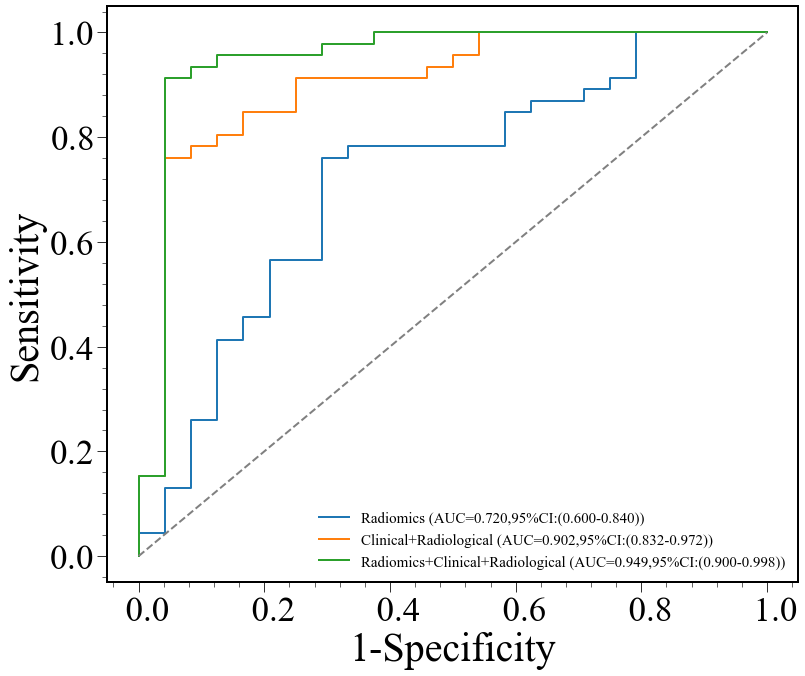

In [139]:
plt.clf()
fig = plt.figure(figsize=(12,10))

# Set offset for margin
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_CDSM_XGBoost_true, train_CDSM_XGBoost_score[:,1], 'Train set', ax, positive=1)
roc_plot_inside(DSM3_RandomForest_true, DSM3_RandomForest_score[:,1], 'Radiomics', ax, positive=1)
roc_plot_inside(Clinical_LogisticRegression_true, Clinical_LogisticRegression_score[:,1], 'Clinical+Radiological', ax, positive=1)
roc_plot_inside(CliRadio_test_true, CliRadio_test_score[:,1], 'Radiomics+Clinical+Radiological', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
#ax.set_title('Internal test', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/Internal_test.png", dpi=300, bbox_inches='tight')

#### External test

(-0.05, 1.05)

(-0.05, 1.05)

Text(0, 0.5, 'Sensitivity')

Text(0.5, 0, '1-Specificity')

<Figure size 864x720 with 0 Axes>

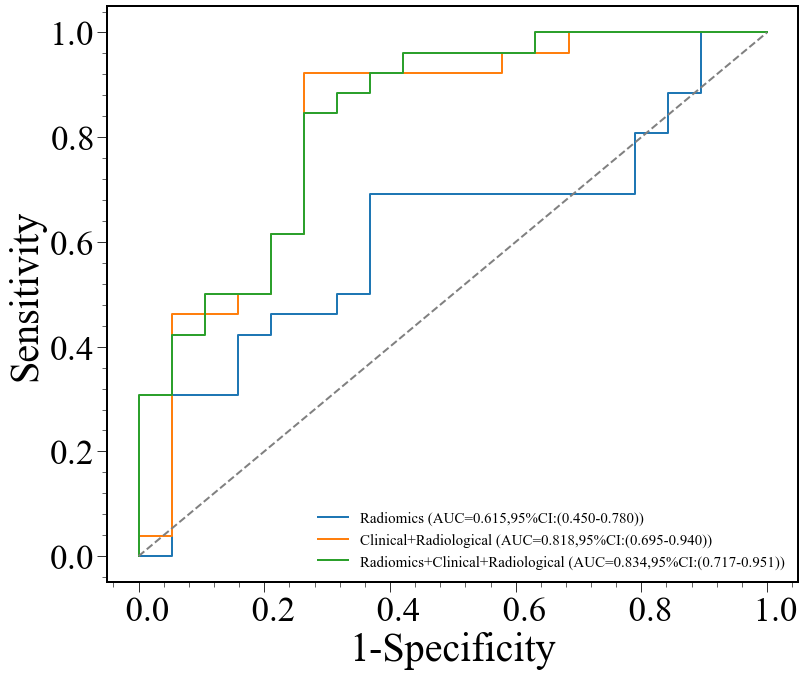

In [140]:
plt.clf()
fig = plt.figure(figsize=(12,10))

# Set offset for margin
left, bottom, width, height = 0.10, 0.10, 0.8, 0.8
ax = fig.add_axes([left,bottom,width,height])
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)

# roc_plot_inside(train_CDSM_XGBoost_true, train_CDSM_XGBoost_score[:,1], 'Train set', ax, positive=1)
roc_plot_inside(exDSM3_RandomForest_true, exDSM3_RandomForest_score[:,1], 'Radiomics', ax, positive=1)
roc_plot_inside(exClinical_LogisticRegression_true, exClinical_LogisticRegression_score[:,1], 'Clinical+Radiological', ax, positive=1)
roc_plot_inside(CliRadio_extest_true, CliRadio_extest_score[:,1], 'Radiomics+Clinical+Radiological', ax, positive=1)
ax.plot([0, 1], [0, 1], lw=2, color='grey', linestyle='--')
# Set width of retangle
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(labelsize=40)

# Set x, y-axis label and fontsize.
ax.set_ylabel('Sensitivity')
ax.set_xlabel('1-Specificity')
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)

# Set ticks
ax.tick_params(labelsize=35)
ax.tick_params(which='major',length=10)
ax.tick_params(which='minor',length=5)
xinter = 0.2
yinter = 0.2
xmajorLocator   = MultipleLocator(xinter) #将x主刻度标签设置为20的倍数
xmajorFormatter = FormatStrFormatter('%5.1f') #设置x轴标签文本的格式
xminorLocator   = MultipleLocator(xinter/5) #将x轴次刻度标签设置为5的倍数
ymajorLocator   = MultipleLocator(yinter) #将y轴主刻度标签设置为0.2的倍数
ymajorFormatter = FormatStrFormatter('%5.1f') #设置y轴标签文本的格式
yminorLocator   = MultipleLocator(yinter/5) #将此y轴次刻度标签设置为0.1的倍数
ax.xaxis.set_major_locator(xmajorLocator)
ax.xaxis.set_major_formatter(xmajorFormatter)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')
#显示次刻度标签的位置,没有标签文本
ax.xaxis.set_minor_locator(xminorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
ax.yaxis.offsetText.set_fontsize(30)
#ax.set_title('External test', fontsize=30)

legend = ax.legend(loc = 0, prop=font1)#, prop = font1, framealpha=1.0)
frame = legend.get_frame()
frame.set_alpha(0)
frame.set_facecolor('none') # 设置图例legend背景透明
fig.savefig("./IMG/External_test.png", dpi=300, bbox_inches='tight')

## Delong test

In [141]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
from sklearn import metrics

class DelongTest():
    def __init__(self,preds1,preds2,label,threshold=0.05):
        '''
        preds1:the output of model1
        preds2:the output of model2
        label :the actual label
        '''
        self._preds1=preds1
        self._preds2=preds2
        self._label=label
        self.threshold=threshold
        #self._show_result()

    def _auc(self,X, Y)->float:
        return 1/(len(X)*len(Y)) * sum([self._kernel(x, y) for x in X for y in Y])

    def _kernel(self,X, Y)->float:
        '''
        Mann-Whitney statistic
        '''
        return .5 if Y==X else int(Y < X)

    def _structural_components(self,X, Y)->list:
        V10 = [1/len(Y) * sum([self._kernel(x, y) for y in Y]) for x in X]
        V01 = [1/len(X) * sum([self._kernel(x, y) for x in X]) for y in Y]
        return V10, V01

    def _get_S_entry(self,V_A, V_B, auc_A, auc_B)->float:
        return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
    
    def _z_score(self,var_A, var_B, covar_AB, auc_A, auc_B):
        return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB )**(.5)+ 1e-8)

    def _group_preds_by_label(self,preds, actual)->list:
        X = [p for (p, a) in zip(preds, actual) if a]
        Y = [p for (p, a) in zip(preds, actual) if not a]
        return X, Y

    def _compute_z_p(self):
        X_A, Y_A = self._group_preds_by_label(self._preds1, self._label)
        X_B, Y_B = self._group_preds_by_label(self._preds2, self._label)

        V_A10, V_A01 = self._structural_components(X_A, Y_A)
        V_B10, V_B01 = self._structural_components(X_B, Y_B)

        auc_A = self._auc(X_A, Y_A)
        auc_B = self._auc(X_B, Y_B)

        # Compute entries of covariance matrix S (covar_AB = covar_BA)
        var_A = (self._get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
        var_B = (self._get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)+ self._get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
        covar_AB = (self._get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)+ self._get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

        # Two tailed test
        z = self._z_score(var_A, var_B, covar_AB, auc_A, auc_B)
        p = st.norm.sf(abs(z))*2

        return z,p

    def _show_result(self):
        z,p=self._compute_z_p()
        print(f"z score = {z:.5f};\np value = {p:.5f};")
        if p < self.threshold :
            print("There is a significant difference")
        else:
            print("There is NO significant difference")


In [142]:
# Model A (random) vs. "good" model B
preds_A = np.array([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5])
preds_B = np.array([.2, .5, .1, .4, .9, .8, .7, .5, .9, .8])
actual = np.array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1])
DelongTest(preds_A,preds_B,actual)

### Five Models

In [143]:
score_list = [CDSM_SVM_score[:,1],
              CDSM_LogisticRegression_score[:,1],
              CDSM_RandomForest_score[:,1],
              CDSM_LightGBM_score[:,1],
              CDSM_XGBoost_score[:,1] 
             ]
y_true = CDSM_XGBoost_true

for i, s1 in enumerate(score_list):
    for j, s2 in enumerate(score_list):
        print(f'{i}-{j} p-value = {DelongTest(s1, s2, y_true)._compute_z_p()[1]}')

0-0 p-value = 1.0
0-1 p-value = 9.170846192729927e-08
0-2 p-value = 1.4839701570638808e-07
0-3 p-value = 1.5613159179754133e-05
0-4 p-value = 0.0004691690694227749
1-0 p-value = 9.170846192729927e-08
1-1 p-value = 1.0
1-2 p-value = 0.2840081364156426
1-3 p-value = 0.018857073154764727
1-4 p-value = 0.0039459933916147286
2-0 p-value = 1.4839701570638808e-07
2-1 p-value = 0.2840081364156426
2-2 p-value = 1.0
2-3 p-value = 0.05104471431142288
2-4 p-value = 0.0012501129625291099
3-0 p-value = 1.5613159179754133e-05
3-1 p-value = 0.018857073154764727
3-2 p-value = 0.05104471431142288
3-3 p-value = 1.0
3-4 p-value = 0.028790088131941977
4-0 p-value = 0.0004691690694227749
4-1 p-value = 0.0039459933916147286
4-2 p-value = 0.0012501129625291099
4-3 p-value = 0.028790088131941977
4-4 p-value = 1.0


In [144]:
score_list = [exClinical_SVM_score[:,1],
              exClinical_LogisticRegression_score[:,1],
              exClinical_RandomForest_score[:,1],
              exClinical_LightGBM_score[:,1],
              exClinical_XGBoost_score[:,1] 
             ]
y_true = exClinical_XGBoost_true

for i, s1 in enumerate(score_list):
    for j, s2 in enumerate(score_list):
        print(f'{i}-{j} p-value = {DelongTest(s1, s2, y_true)._compute_z_p()[1]}')

0-0 p-value = 1.0
0-1 p-value = 0.13820391595616366
0-2 p-value = 0.08465688397925632
0-3 p-value = 0.021527134263030018
0-4 p-value = 0.6804227606555255
1-0 p-value = 0.13820391595616366
1-1 p-value = 1.0
1-2 p-value = 0.6015969321317338
1-3 p-value = 0.38381600708905017
1-4 p-value = 0.3712096359868955
2-0 p-value = 0.08465688397925632
2-1 p-value = 0.6015969321317338
2-2 p-value = 1.0
2-3 p-value = 0.696135939808485
2-4 p-value = 0.1253908447321864
3-0 p-value = 0.021527134263030018
3-1 p-value = 0.38381600708905017
3-2 p-value = 0.696135939808485
3-3 p-value = 1.0
3-4 p-value = 0.01642469087434983
4-0 p-value = 0.6804227606555255
4-1 p-value = 0.3712096359868955
4-2 p-value = 0.1253908447321864
4-3 p-value = 0.01642469087434983
4-4 p-value = 1.0


### Logistic internal

In [148]:
score_list = [DSM3_RandomForest_score[:,1],
              Clinical_LogisticRegression_score[:,1],
              #Clinical_SVM_score[:,1],
              CliRadio_test_score[:,1],
             ]
score_list
y_true = DSM3_LogisticRegression_true 

for i, s1 in enumerate(score_list):
    for j, s2 in enumerate(score_list):
        print(f'{i}-{j} p-value = {DelongTest(s1, s2, y_true)._compute_z_p()[1]}')

[array([0.56169788, 0.59803706, 0.59430793, 0.66855421, 0.69607569,
        0.6078801 , 0.65497087, 0.44832812, 0.44887143, 0.54862804,
        0.65769903, 0.5854265 , 0.36684809, 0.66396469, 0.7340391 ,
        0.39561047, 0.23742617, 0.61685236, 0.69421896, 0.67578883,
        0.55040943, 0.65692613, 0.39305722, 0.61776268, 0.64305499,
        0.48143329, 0.63337338, 0.61900803, 0.7596178 , 0.52999389,
        0.65422178, 0.7175406 , 0.59770455, 0.14500953, 0.50469562,
        0.6203577 , 0.351463  , 0.52195222, 0.59335819, 0.57066289,
        0.47052745, 0.59924592, 0.53418452, 0.55747632, 0.33900746,
        0.57377256, 0.3584406 , 0.55504798, 0.66649811, 0.64616579,
        0.58642202, 0.47052198, 0.4562383 , 0.25441733, 0.43522678,
        0.52834578, 0.68322263, 0.52018547, 0.74453433, 0.50801957,
        0.48853061, 0.39442838, 0.46502004, 0.46298126, 0.55922655,
        0.66897148, 0.47064774, 0.67763541, 0.25838802, 0.7844657 ]),
 array([0.13189949, 0.51712184, 0.74788939, 0.

0-0 p-value = 1.0
0-1 p-value = 0.01137680494396875
0-2 p-value = 0.00044536248080539103
1-0 p-value = 0.01137680494396875
1-1 p-value = 1.0
1-2 p-value = 0.03055531491135541
2-0 p-value = 0.00044536248080539103
2-1 p-value = 0.03055531491135541
2-2 p-value = 1.0


In [149]:
score_list = [exDSM3_RandomForest_score[:,1],
              exClinical_LogisticRegression_score[:,1],
              CliRadio_extest_score[:,1],
             ]
score_list
y_true = exDSM3_LogisticRegression_true 

for i, s1 in enumerate(score_list):
    for j, s2 in enumerate(score_list):
        print(f'{i}-{j} p-value = {DelongTest(s1, s2, y_true)._compute_z_p()[1]}')

[array([0.57456027, 0.21903961, 0.56616376, 0.51289654, 0.52875272,
        0.46830877, 0.61896766, 0.82117708, 0.69688361, 0.6264376 ,
        0.73188216, 0.62019832, 0.6917192 , 0.44882189, 0.69058959,
        0.14561729, 0.48349423, 0.51534399, 0.64897603, 0.45140973,
        0.54092972, 0.62943531, 0.30239134, 0.57926553, 0.34957638,
        0.58867772, 0.58028867, 0.336559  , 0.60847548, 0.4645158 ,
        0.62406733, 0.49794744, 0.22390083, 0.63334909, 0.59549441,
        0.54052997, 0.4307464 , 0.59613354, 0.46055097, 0.44189858,
        0.48353914, 0.50339123, 0.48370703, 0.41807368, 0.45410044]),
 array([0.39285883, 0.03204561, 0.03442032, 0.97985594, 0.99963946,
        0.17094399, 0.98254552, 0.99947286, 0.99612932, 0.82999037,
        0.99148344, 0.08025064, 0.90243132, 0.99734551, 0.99188586,
        0.03516619, 0.28544207, 0.52829463, 0.9909849 , 0.89781638,
        0.84280181, 0.92456806, 0.07151891, 0.95059571, 0.11401832,
        0.98979536, 0.92185001, 0.74759273, 0.

0-0 p-value = 1.0
0-1 p-value = 0.012243903455795643
0-2 p-value = 0.011058868861182798
1-0 p-value = 0.012243903455795643
1-1 p-value = 1.0
1-2 p-value = 0.47293376395245723
2-0 p-value = 0.011058868861182798
2-1 p-value = 0.47293376395245723
2-2 p-value = 1.0


## Nomogram

In [147]:
Clinical_train = pd.read_csv(os.path.join(traindir, 'clinical_lasso_sel.csv')) 
nomogram_feas = Clinical_train.columns.values
nomogram_feas

clinical_nomo_df = pd.read_csv('../DataPreprocess/dataset_info/clinical_data.csv')
clinical_nomo_df = clinical_nomo_df[nomogram_feas]
clinical_nomo_df.rename(columns={
    'mass_feature':'Mass_feature', 
    'diaphram_nodule':'Diaphram_nodule', 
    'parenchymal_organs':'Parenchymal_organs', 
    'ascites_amount':'Amount_of_ascites',
    'relationship_on_T1_dual_echo_images':'Relationship',
    'peritoneum_mesentery_nodules':'Peritoneum_mesentery_nodules',
}, inplace=True)
clinical_nomo_df.tail()

DSM3_train = pd.read_excel(os.path.join(traindir, 'DSM_feas_mrmr_sel.xlsx'), sheet_name=f'no_sequence3')
DSM3_train['Radiomics_score'] = train_DSM3_RandomForest_score[:,1]
DSM3_train_df = DSM3_train[['pid', 'Radiomics_score']]

DSM3_test = pd.read_excel(os.path.join(testdir, 'DSM_test.xlsx'), sheet_name=f'no_sequence3')
DSM3_test['Radiomics_score'] = DSM3_RandomForest_score[:,1]
DSM3_test_df = DSM3_test[['pid', 'Radiomics_score']]

Radiomics_score_df = pd.concat([DSM3_train_df, DSM3_test_df], axis=0)
Radiomics_score_df = DSM3_train_df
Clinical_train.head()

clinical_nomo_df = pd.merge(Radiomics_score_df,clinical_nomo_df, on='pid', how='left')
clinical_nomo_df['Radiomics_score'].isna().sum()
len(clinical_nomo_df)
clinical_nomo_df = clinical_nomo_df.rename(columns={'ascites_amount':'amount_of_ascites'})
clinical_nomo_df.to_csv('nomogram_feas_orignal.csv', index=0)

array(['pid', 'label', 'mass_feature', 'NLR', 'diaphram_nodule', 'CA125',
       'parenchymal_organs', 'HE4', 'ascites_amount',
       'relationship_on_T1_dual_echo_images',
       'peritoneum_mesentery_nodules', 'LDH'], dtype=object)

,pid,label,Mass_feature,NLR,Diaphram_nodule,CA125,Parenchymal_organs,HE4,Amount_of_ascites,Relationship,Peritoneum_mesentery_nodules,LDH
223,231,1,2,2.84,0,1171.4,0,277.0,2,2,1,274.0
224,232,0,2,3.75,0,975.8,0,432.0,2,1,1,359.0
225,233,1,2,4.27,1,682.8,1,1198.0,2,2,1,420.0
226,234,0,3,2.99,0,388.4,0,99.0,1,2,0,166.0
227,235,0,2,1.46,0,307.7,0,57.0,1,2,1,199.0


,pid,label,mass_feature,NLR,diaphram_nodule,CA125,parenchymal_organs,HE4,ascites_amount,relationship_on_T1_dual_echo_images,peritoneum_mesentery_nodules,LDH
0,1,0,3,-0.979298,0,-0.619137,0,-0.567482,1,0,0,-0.493932
1,2,1,2,0.436419,0,-0.520656,0,-0.399017,1,3,1,-0.315683
2,3,1,3,-0.368746,0,0.381479,0,-0.360563,1,2,0,-0.258967
3,4,0,3,2.825204,0,-0.398053,0,-0.071242,1,3,0,0.956370
4,8,1,3,1.657523,0,0.425421,0,-0.221396,2,3,1,-0.372399


0

158